In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

from evaluation import eval, eval_multi, logger, MODE_ADVERSARY, MODE_ADVERSARY_RANDOMIZE, MODE_RANDOM, MODE_ADV_TASK_DIVERSITY
%load_ext autoreload
%autoreload 2

In [3]:
T = 500 # Timesteps/horizon
n_task = 4000
alpha_set = [1.0] # Bonus for UCB
v_set = [1.0] # Bonus for TS
alpha_PHE_set = [1.0] # Bonus for PHE
tau_1_PEGE_set = [T//2] # EXR length for PEGE
is_multi = True
input_dict = {
    "d":10, # n_dims
    "unit_ball_action": True,
    # "n_gen_context":20, #if not unit ball action set, how many action sampled from the action set
    "T":T, # Timesteps/horizon
    "n_sim":5, # Number of Simulations
    "rho":0.5,
    "noise_std":1,
    "seed":None, #TODO: bug here, must set to None
    "output":True,
    "params_set":alpha_set,
    "m":3, # n_dims latent
    "n_task":n_task,
    "mode":MODE_ADV_TASK_DIVERSITY,
    "adv_exr_const":0.1, # scaling factor for adversary task generation
    "adv_exr_task":None, # specific tasks to reveal a new dimension
    "PMA_exr_const":1.5, # scaling factor for exploration probability
    "PMA_lr_const":1, # scaling factor for the learning rate
    "PMA_n_expert":100000, # Expert set size for PMA
    "PMA_tau1_const":1, # scaling factor for PEGE's EXR length in the EXR phase
    "PMA_tau2_const":1, # scaling factor for PEGE's EXR length in the EXT phase
    "PMA_alpha_const":1, # scaling factor for PMA's alpha threshold
    "p_decay_rate":0, # decay rate for EXR prob. May be useful for Task Diversity setting
    "PMA_stop_exr":n_task, # Stop EXR after PMA_stop_exr step
    "PMA_no_oracle":False,
    "SeqRepL_exr_const":1.5,
    "SeqRepL_tau1_const":1,
    "SeqRepL_tau2_const":1,
    "SeqRepL_stop_exr":n_task, # Stop EXR after PMA_stop_exr step
    "fixed_params":[0.1, 400, 50], # fixed params for [p, tau1, tau2]
    "SeqRepL_exr_list": None
}

def get_SeqRepL_exr_list(n_task):
    SeqRepL_exr_list = []
    i=0
    while i**2 <= n_task:
        SeqRepL_exr_list.append(i**2)
        i+=1
    return SeqRepL_exr_list

def check_params():
    m = input_dict["m"]
    d = input_dict["d"]
    assert m<=d, "m >= d"
    assert m<=d, "m >= d"
    if T<d**2:
        logger.info(f"Warning: T < d**2")
    if n_task < np.sqrt(T):
        logger.info(f"Warning: n_task < np.sqrt(T)")
    if input_dict["adv_exr_task"] is not None:
        assert max(input_dict["adv_exr_task"]) < input_dict["n_task"], f"max exr task ({max(input_dict["adv_exr_task"])}) is larger than n_task ({input_dict["n_task"]})"
        assert len(input_dict["adv_exr_task"]) == input_dict["m"], f"exr list (len={len(input_dict["adv_exr_task"])}) is incorrect (!= m ({input_dict["m"]}))"

# With Task Diversity

In [3]:
# n_task = 4000
# input_dict["mode"] = MODE_ADV_TASK_DIVERSITY
# input_dict["adv_exr_const"] = 0.1 #0.09
# input_dict["n_sim"] = 5
# input_dict["m"] = 3
# input_dict["d"] = 10
# input_dict["T"] = 500
# input_dict["noise_std"] = 1
# input_dict["n_task"] = n_task
# input_dict["PMA_n_expert"] = 100000
check_params()

In [4]:
input_dict["name"] = "PEGE"
# input_dict["params_set"] = [25] # tau_1
input_dict["params_set"] = [190, 210] # tau_1
best_PEGE = eval_multi(input_dict)

PEGE Simulation 1, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:14:38 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:14:38 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:14:38 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [01:14<00:00, 54.02it/s]


PEGE Simulation 2, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:15:52 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:15:52 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:15:52 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [01:11<00:00, 56.29it/s]


PEGE Simulation 3, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:17:03 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:17:03 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:17:03 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [01:10<00:00, 56.43it/s]


PEGE Simulation 4, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:18:14 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:18:14 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:18:14 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [01:10<00:00, 56.78it/s]


PEGE Simulation 5, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:19:24 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:19:24 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:19:24 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [01:09<00:00, 57.83it/s]


PEGE Simulation 1, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:20:34 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:20:34 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:20:34 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [01:16<00:00, 52.19it/s]


PEGE Simulation 2, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:21:50 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:21:50 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:21:50 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [01:14<00:00, 53.40it/s]


PEGE Simulation 3, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:23:05 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:23:05 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:23:05 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [01:13<00:00, 54.36it/s]


PEGE Simulation 4, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:24:19 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:24:19 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:24:19 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [01:13<00:00, 54.23it/s]


PEGE Simulation 5, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:25:32 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:25:32 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:25:33 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [01:13<00:00, 54.16it/s]

2024-05-24 08:26:46 idx of params chosen: 0


In [5]:
input_dict["name"] = "PEGE_oracle"
# input_dict["params_set"] = [2] # tau_2
input_dict["params_set"] = [45, 55] # tau_2
best_PEGE_oracle = eval_multi(input_dict)

PEGE_oracle Simulation 1, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:26:46 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:26:46 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:26:46 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:26<00:00, 150.34it/s]


PEGE_oracle Simulation 2, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:27:13 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:27:13 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:27:13 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:26<00:00, 149.36it/s]


PEGE_oracle Simulation 3, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:27:40 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:27:40 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:27:40 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:27<00:00, 142.95it/s]


PEGE_oracle Simulation 4, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:28:08 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:28:08 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:28:08 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:26<00:00, 150.55it/s]


PEGE_oracle Simulation 5, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:28:34 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:28:34 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:28:34 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:26<00:00, 150.73it/s]


PEGE_oracle Simulation 1, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:29:01 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:29:01 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:29:01 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:27<00:00, 146.96it/s]


PEGE_oracle Simulation 2, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:29:28 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:29:28 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:29:28 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:27<00:00, 147.21it/s]


PEGE_oracle Simulation 3, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:29:55 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:29:55 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:29:55 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:27<00:00, 146.87it/s]


PEGE_oracle Simulation 4, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:30:22 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:30:22 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:30:22 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:27<00:00, 147.12it/s]


PEGE_oracle Simulation 5, N_gen_ctx=20, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:30:50 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:30:50 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:30:50 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:27<00:00, 144.67it/s]

2024-05-24 08:31:17 idx of params chosen: 1


In [6]:
input_dict["name"] = "PMA"
input_dict["params_set"] = [None] # Placeholder
input_dict["PMA_no_oracle"] = False
# input_dict["PMA_exr_const"] = 0.45 # (0.45) p=0.1 is good for n_task=500, d=10, m=3, T=500. 0.23 for n_task=300
# input_dict["PMA_tau1_const"] = 0.75 #Large enough to have a good estimate of theta. tau_1 = 150 is good for d=10
# input_dict["PMA_tau2_const"] = 0.5 #tau_2 = 20 is ok for m = 3
# input_dict["PMA_alpha_const"] = 0.3 #0.45 for n_task=500. Small enough to filter wrong experts. Not too small to exclude the true expert

# input_dict["PMA_exr_const"] = 0.65
# input_dict["PMA_tau1_const"] = 1.75
# input_dict["PMA_tau2_const"] = 0.8
# input_dict["PMA_alpha_const"] = 1.35
# # input_dict["PMA_n_expert"] = 20

# input_dict["PMA_n_expert"] = 100000
# input_dict["PMA_exr_const"] = 1.75
# input_dict["PMA_tau1_const"] = 2.5
# input_dict["PMA_alpha_const"] = 1.5 #1.5
# input_dict["PMA_stop_exr"] = n_task

# Below is No Div params. Above is Div params
input_dict["PMA_exr_const"] = 1 # 1.75
input_dict["PMA_tau1_const"] = 2.5 #2.5
input_dict["PMA_tau2_const"] = 0.8 #
input_dict["PMA_alpha_const"] = 1.35 #1.35, 1.5
input_dict["PMA_no_oracle"] = False
input_dict["PMA_stop_exr"] = n_task
best_PMA = eval_multi(input_dict)

PMA Simulation 1, N_gen_ctx=20, d=10
2024-05-24 08:31:20 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 08:31:20 PMA's exp prob = 0.09, tau_1 = 427.5, tau_2 = 53.669999999999995


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:31:20 ==== [Adv reveals] 1/3 dims with prob q = 1


  0%|          | 1/4000 [00:00<30:51,  2.16it/s]

2024-05-24 08:31:20 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:31:20 ==== [Adv reveals] 3/3 dims with prob q = 1


  2%|▏         | 60/4000 [00:05<03:14, 20.30it/s]

2024-05-24 08:31:25 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  6%|▋         | 256/4000 [00:14<01:49, 34.15it/s]

2024-05-24 08:31:35 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 14%|█▍        | 556/4000 [00:27<01:58, 28.98it/s]

2024-05-24 08:31:47 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 17%|█▋        | 662/4000 [00:32<01:44, 32.03it/s]

2024-05-24 08:31:52 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 18%|█▊        | 703/4000 [00:35<03:36, 15.23it/s]

2024-05-24 08:31:56 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 20%|██        | 812/4000 [00:40<04:03, 13.11it/s]

2024-05-24 08:32:01 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 21%|██        | 832/4000 [00:41<02:46, 19.01it/s]

 24%|██▎       | 941/4000 [00:47<01:51, 27.50it/s]

2024-05-24 08:32:08 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 27%|██▋       | 1091/4000 [00:56<01:37, 29.73it/s]

2024-05-24 08:32:16 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 28%|██▊       | 1106/4000 [00:56<01:41, 28.54it/s]

2024-05-24 08:32:17 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 32%|███▏      | 1265/4000 [01:05<03:03, 14.92it/s]

2024-05-24 08:32:25 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 35%|███▍      | 1382/4000 [01:11<01:32, 28.45it/s]

2024-05-24 08:32:31 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 36%|███▋      | 1452/4000 [01:14<01:43, 24.68it/s]

2024-05-24 08:32:35 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 37%|███▋      | 1498/4000 [01:18<04:33,  9.15it/s]

2024-05-24 08:32:39 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 38%|███▊      | 1524/4000 [01:20<02:22, 17.33it/s]

2024-05-24 08:32:40 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 39%|███▉      | 1555/4000 [01:22<02:58, 13.68it/s]

2024-05-24 08:32:42 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 45%|████▌     | 1815/4000 [01:37<02:28, 14.68it/s]

2024-05-24 08:32:57 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 46%|████▌     | 1831/4000 [01:38<02:32, 14.22it/s]

2024-05-24 08:32:59 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 49%|████▉     | 1963/4000 [01:43<01:01, 32.96it/s]

2024-05-24 08:33:03 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 52%|█████▏    | 2088/4000 [01:51<01:47, 17.77it/s]

2024-05-24 08:33:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 60%|██████    | 2413/4000 [02:05<02:46,  9.56it/s]

2024-05-24 08:33:26 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 61%|██████▏   | 2455/4000 [02:07<01:03, 24.17it/s]

2024-05-24 08:33:28 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 64%|██████▍   | 2564/4000 [02:12<00:55, 26.01it/s]

2024-05-24 08:33:33 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 65%|██████▌   | 2614/4000 [02:16<01:38, 14.06it/s]

2024-05-24 08:33:37 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 70%|██████▉   | 2780/4000 [02:24<01:16, 15.85it/s]

2024-05-24 08:33:45 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 70%|██████▉   | 2795/4000 [02:27<02:58,  6.75it/s]

2024-05-24 08:33:47 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 77%|███████▋  | 3076/4000 [02:45<00:39, 23.53it/s]

2024-05-24 08:34:06 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 79%|███████▉  | 3178/4000 [02:52<00:59, 13.84it/s]

2024-05-24 08:34:13 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 82%|████████▏ | 3261/4000 [02:58<00:49, 14.89it/s]

2024-05-24 08:34:19 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 84%|████████▍ | 3376/4000 [03:03<00:29, 21.39it/s]

2024-05-24 08:34:24 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 88%|████████▊ | 3520/4000 [03:12<00:29, 16.22it/s]

2024-05-24 08:34:33 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 90%|████████▉ | 3592/4000 [03:16<00:15, 25.81it/s]

2024-05-24 08:34:36 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 91%|█████████ | 3643/4000 [03:19<00:18, 18.84it/s]

2024-05-24 08:34:40 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 92%|█████████▏| 3673/4000 [03:21<00:16, 19.61it/s]

2024-05-24 08:34:42 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 93%|█████████▎| 3732/4000 [03:28<00:27,  9.64it/s]

2024-05-24 08:34:48 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 94%|█████████▎| 3747/4000 [03:29<00:18, 13.57it/s]

2024-05-24 08:34:49 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 95%|█████████▍| 3787/4000 [03:31<00:09, 22.15it/s]

2024-05-24 08:34:52 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 96%|█████████▌| 3830/4000 [03:34<00:12, 13.55it/s]

2024-05-24 08:34:55 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 96%|█████████▋| 3854/4000 [03:36<00:08, 17.26it/s]

2024-05-24 08:34:56 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 96%|█████████▋| 3859/4000 [03:36<00:09, 14.50it/s]

2024-05-24 08:34:57 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 97%|█████████▋| 3891/4000 [03:39<00:09, 10.93it/s]

2024-05-24 08:35:00 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [03:46<00:00, 17.68it/s]


PMA Simulation 2, N_gen_ctx=20, d=10
2024-05-24 08:35:08 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 08:35:08 PMA's exp prob = 0.09, tau_1 = 427.5, tau_2 = 53.669999999999995


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:35:08 ==== [Adv reveals] 1/3 dims with prob q = 1


  0%|          | 1/4000 [00:00<31:38,  2.11it/s]

2024-05-24 08:35:09 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:35:09 ==== [Adv reveals] 3/3 dims with prob q = 1


  1%|▏         | 51/4000 [00:02<03:03, 21.53it/s]

2024-05-24 08:35:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  2%|▏         | 78/4000 [00:05<05:20, 12.22it/s]

2024-05-24 08:35:15 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  6%|▌         | 230/4000 [00:12<01:27, 43.29it/s]

2024-05-24 08:35:21 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  8%|▊         | 330/4000 [00:17<01:17, 47.09it/s]

2024-05-24 08:35:26 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 11%|█         | 434/4000 [00:24<02:34, 23.15it/s]

2024-05-24 08:35:33 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 16%|█▌        | 629/4000 [00:32<03:23, 16.60it/s]

2024-05-24 08:35:41 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 16%|█▋        | 652/4000 [00:34<03:56, 14.13it/s]

2024-05-24 08:35:44 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 17%|█▋        | 689/4000 [00:37<03:24, 16.22it/s]

2024-05-24 08:35:46 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 20%|█▉        | 788/4000 [00:44<03:56, 13.56it/s]

2024-05-24 08:35:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 23%|██▎       | 910/4000 [00:49<00:48, 63.12it/s]

2024-05-24 08:35:59 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 23%|██▎       | 937/4000 [00:51<02:12, 23.15it/s]

2024-05-24 08:36:01 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▌       | 1001/4000 [00:55<03:03, 16.39it/s]

2024-05-24 08:36:04 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▌       | 1013/4000 [00:55<02:32, 19.59it/s]

2024-05-24 08:36:04 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 26%|██▋       | 1058/4000 [00:58<02:39, 18.48it/s]

2024-05-24 08:36:07 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 28%|██▊       | 1107/4000 [01:00<02:04, 23.27it/s]

2024-05-24 08:36:09 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 28%|██▊       | 1130/4000 [01:01<02:56, 16.24it/s]

2024-05-24 08:36:10 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 30%|███       | 1211/4000 [01:06<02:52, 16.16it/s]

2024-05-24 08:36:16 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 31%|███       | 1233/4000 [01:07<01:41, 27.39it/s]

2024-05-24 08:36:16 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 35%|███▍      | 1384/4000 [01:15<03:49, 11.38it/s]

2024-05-24 08:36:24 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 35%|███▍      | 1389/4000 [01:16<05:13,  8.32it/s]

2024-05-24 08:36:25 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 38%|███▊      | 1505/4000 [01:22<02:00, 20.79it/s]

2024-05-24 08:36:31 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 40%|███▉      | 1583/4000 [01:27<01:05, 36.86it/s]

2024-05-24 08:36:36 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 41%|████      | 1644/4000 [01:29<01:22, 28.69it/s]

2024-05-24 08:36:38 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 41%|████▏     | 1658/4000 [01:30<01:53, 20.63it/s]

2024-05-24 08:36:39 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 50%|████▉     | 1984/4000 [01:43<01:04, 31.47it/s]

2024-05-24 08:36:52 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 60%|█████▉    | 2382/4000 [02:01<01:17, 20.84it/s]

2024-05-24 08:37:10 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 71%|███████   | 2830/4000 [02:24<00:55, 21.10it/s]

2024-05-24 08:37:33 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 72%|███████▏  | 2869/4000 [02:27<01:06, 16.92it/s]

2024-05-24 08:37:36 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 72%|███████▏  | 2882/4000 [02:28<01:48, 10.32it/s]

2024-05-24 08:37:37 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 75%|███████▌  | 3016/4000 [02:36<00:40, 24.16it/s]

2024-05-24 08:37:45 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 84%|████████▎ | 3342/4000 [02:54<00:41, 15.82it/s]

2024-05-24 08:38:03 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 84%|████████▍ | 3352/4000 [02:55<00:53, 12.18it/s]

2024-05-24 08:38:04 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 86%|████████▌ | 3422/4000 [02:58<00:21, 26.45it/s]

2024-05-24 08:38:07 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 89%|████████▉ | 3576/4000 [03:06<00:15, 27.84it/s]

2024-05-24 08:38:15 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 91%|█████████ | 3628/4000 [03:08<00:16, 22.17it/s]

2024-05-24 08:38:17 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 92%|█████████▏| 3672/4000 [03:11<00:22, 14.51it/s]

2024-05-24 08:38:20 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 93%|█████████▎| 3704/4000 [03:13<00:09, 31.41it/s]

2024-05-24 08:38:22 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 97%|█████████▋| 3870/4000 [03:22<00:06, 20.32it/s]

2024-05-24 08:38:32 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 97%|█████████▋| 3897/4000 [03:25<00:08, 11.54it/s]

2024-05-24 08:38:34 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [03:29<00:00, 19.13it/s]


PMA Simulation 3, N_gen_ctx=20, d=10
2024-05-24 08:38:40 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 08:38:40 PMA's exp prob = 0.09, tau_1 = 427.5, tau_2 = 53.669999999999995


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:38:40 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 08:38:40 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.
2024-05-24 08:38:40 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const


  0%|          | 1/4000 [00:00<31:18,  2.13it/s]

2024-05-24 08:38:40 ==== [Adv reveals] 2/3 dims with prob q = 1


  0%|          | 2/4000 [00:00<31:02,  2.15it/s]

2024-05-24 08:38:40 ==== [Adv reveals] 3/3 dims with prob q = 1


  2%|▏         | 88/4000 [00:06<05:26, 12.00it/s]

2024-05-24 08:38:46 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  4%|▍         | 167/4000 [00:09<02:54, 21.91it/s]

2024-05-24 08:38:50 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.
2024-05-24 08:38:50 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  8%|▊         | 315/4000 [00:20<04:18, 14.27it/s]

2024-05-24 08:39:01 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 10%|█         | 403/4000 [00:25<04:31, 13.25it/s]

2024-05-24 08:39:06 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 11%|█         | 431/4000 [00:27<02:55, 20.35it/s]

2024-05-24 08:39:08 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 11%|█         | 443/4000 [00:28<04:00, 14.77it/s]

2024-05-24 08:39:09 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 14%|█▍        | 561/4000 [00:35<05:41, 10.07it/s]

2024-05-24 08:39:15 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 14%|█▍        | 570/4000 [00:36<05:51,  9.76it/s]

2024-05-24 08:39:16 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 18%|█▊        | 731/4000 [00:43<02:02, 26.69it/s]

2024-05-24 08:39:23 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 19%|█▉        | 777/4000 [00:44<01:12, 44.46it/s]

2024-05-24 08:39:25 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.
2024-05-24 08:39:25 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 27%|██▋       | 1067/4000 [00:59<01:48, 26.95it/s]

2024-05-24 08:39:39 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 29%|██▊       | 1143/4000 [01:03<02:44, 17.32it/s]

2024-05-24 08:39:43 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 32%|███▎      | 1300/4000 [01:10<03:53, 11.56it/s]

2024-05-24 08:39:51 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 35%|███▌      | 1416/4000 [01:17<02:37, 16.44it/s]

2024-05-24 08:39:57 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 44%|████▎     | 1742/4000 [01:30<00:33, 67.55it/s]

2024-05-24 08:40:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 48%|████▊     | 1936/4000 [01:42<01:33, 22.10it/s]

2024-05-24 08:40:23 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 49%|████▊     | 1941/4000 [01:43<02:01, 16.88it/s]

2024-05-24 08:40:24 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 49%|████▊     | 1948/4000 [01:44<02:12, 15.48it/s]

2024-05-24 08:40:24 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 50%|████▉     | 1993/4000 [01:45<01:02, 32.21it/s]

2024-05-24 08:40:26 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 52%|█████▏    | 2062/4000 [01:49<01:07, 28.77it/s]

2024-05-24 08:40:29 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 52%|█████▏    | 2068/4000 [01:50<01:31, 21.04it/s]

2024-05-24 08:40:30 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 57%|█████▋    | 2261/4000 [02:00<02:32, 11.39it/s]

2024-05-24 08:40:41 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 57%|█████▋    | 2295/4000 [02:02<01:48, 15.69it/s]

2024-05-24 08:40:42 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 59%|█████▊    | 2346/4000 [02:04<01:07, 24.33it/s]

2024-05-24 08:40:44 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 62%|██████▏   | 2467/4000 [02:11<01:32, 16.56it/s]

2024-05-24 08:40:52 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 62%|██████▏   | 2471/4000 [02:12<02:26, 10.41it/s]

2024-05-24 08:40:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 63%|██████▎   | 2515/4000 [02:14<00:44, 33.47it/s]

2024-05-24 08:40:55 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 64%|██████▍   | 2579/4000 [02:19<02:14, 10.58it/s]

2024-05-24 08:41:00 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 65%|██████▌   | 2608/4000 [02:21<01:09, 20.07it/s]

2024-05-24 08:41:02 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 68%|██████▊   | 2736/4000 [02:29<00:46, 27.13it/s]

2024-05-24 08:41:09 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 70%|██████▉   | 2793/4000 [02:33<00:51, 23.45it/s]

2024-05-24 08:41:13 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 72%|███████▏  | 2890/4000 [02:37<00:52, 21.26it/s]

2024-05-24 08:41:18 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 73%|███████▎  | 2909/4000 [02:38<01:01, 17.81it/s]

2024-05-24 08:41:19 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 75%|███████▌  | 3007/4000 [02:46<01:01, 16.23it/s]

2024-05-24 08:41:26 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 76%|███████▋  | 3056/4000 [02:47<00:20, 46.13it/s]

2024-05-24 08:41:28 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 79%|███████▉  | 3158/4000 [02:55<01:04, 13.15it/s]

2024-05-24 08:41:35 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 80%|████████  | 3220/4000 [02:58<01:05, 11.99it/s]

2024-05-24 08:41:39 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 83%|████████▎ | 3322/4000 [03:03<00:23, 28.44it/s]

2024-05-24 08:41:44 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 84%|████████▎ | 3345/4000 [03:05<00:33, 19.34it/s]

2024-05-24 08:41:45 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 85%|████████▍ | 3392/4000 [03:07<00:15, 39.83it/s]

2024-05-24 08:41:48 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 88%|████████▊ | 3514/4000 [03:14<00:26, 18.42it/s]

2024-05-24 08:41:54 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 89%|████████▉ | 3552/4000 [03:17<00:47,  9.38it/s]

2024-05-24 08:41:58 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 90%|█████████ | 3608/4000 [03:22<00:27, 14.31it/s]

2024-05-24 08:42:03 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 90%|█████████ | 3613/4000 [03:23<00:30, 12.69it/s]

2024-05-24 08:42:03 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 90%|█████████ | 3617/4000 [03:23<00:34, 11.16it/s]

2024-05-24 08:42:04 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 96%|█████████▋| 3853/4000 [03:35<00:03, 40.26it/s]

2024-05-24 08:42:15 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|█████████▉| 3993/4000 [03:43<00:00, 40.75it/s]

2024-05-24 08:42:24 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [03:44<00:00, 17.83it/s]

PMA Simulation 4, N_gen_ctx=20, d=10


2024-05-24 08:42:26 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 08:42:26 PMA's exp prob = 0.09, tau_1 = 427.5, tau_2 = 53.669999999999995


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:42:26 ==== [Adv reveals] 1/3 dims with prob q = 1


  0%|          | 1/4000 [00:00<33:20,  2.00it/s]

2024-05-24 08:42:27 ==== [Adv reveals] 2/3 dims with prob q = 1


  0%|          | 2/4000 [00:00<31:36,  2.11it/s]

2024-05-24 08:42:27 ==== [Adv reveals] 3/3 dims with prob q = 1


  2%|▏         | 71/4000 [00:04<02:41, 24.36it/s]

2024-05-24 08:42:31 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 12%|█▏        | 499/4000 [00:24<01:38, 35.69it/s]

2024-05-24 08:42:51 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 14%|█▍        | 550/4000 [00:26<01:49, 31.57it/s]

2024-05-24 08:42:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 15%|█▌        | 607/4000 [00:29<03:22, 16.77it/s]

2024-05-24 08:42:56 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 16%|█▌        | 620/4000 [00:31<07:51,  7.18it/s]

2024-05-24 08:42:59 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 16%|█▌        | 627/4000 [00:32<06:17,  8.95it/s]

2024-05-24 08:42:59 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 17%|█▋        | 682/4000 [00:34<02:09, 25.65it/s]

2024-05-24 08:43:01 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 18%|█▊        | 739/4000 [00:37<03:24, 15.97it/s]

2024-05-24 08:43:05 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 992/4000 [00:52<01:19, 37.95it/s]

2024-05-24 08:43:19 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 26%|██▌       | 1034/4000 [00:56<04:07, 11.97it/s]

2024-05-24 08:43:23 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 26%|██▋       | 1057/4000 [00:58<03:47, 12.93it/s]

2024-05-24 08:43:25 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 28%|██▊       | 1129/4000 [01:01<01:15, 38.26it/s]

2024-05-24 08:43:28 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 29%|██▊       | 1144/4000 [01:02<01:30, 31.63it/s]

2024-05-24 08:43:29 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 30%|███       | 1220/4000 [01:07<02:01, 22.85it/s]

2024-05-24 08:43:34 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 31%|███       | 1247/4000 [01:09<03:22, 13.59it/s]

2024-05-24 08:43:36 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 32%|███▏      | 1272/4000 [01:10<03:16, 13.89it/s]

2024-05-24 08:43:38 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 32%|███▏      | 1298/4000 [01:13<03:22, 13.32it/s]

2024-05-24 08:43:40 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 33%|███▎      | 1305/4000 [01:14<04:26, 10.13it/s]

2024-05-24 08:43:41 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 35%|███▍      | 1394/4000 [01:17<01:51, 23.32it/s]

2024-05-24 08:43:45 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 37%|███▋      | 1498/4000 [01:20<01:07, 36.89it/s]

2024-05-24 08:43:47 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 44%|████▍     | 1761/4000 [01:35<00:51, 43.49it/s]

2024-05-24 08:44:02 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 45%|████▍     | 1787/4000 [01:36<02:09, 17.06it/s]

2024-05-24 08:44:04 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 48%|████▊     | 1903/4000 [01:41<00:39, 52.55it/s]

2024-05-24 08:44:08 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 48%|████▊     | 1922/4000 [01:42<02:05, 16.60it/s]

2024-05-24 08:44:10 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 56%|█████▌    | 2226/4000 [01:54<00:45, 38.59it/s]

2024-05-24 08:44:22 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 56%|█████▋    | 2257/4000 [01:56<01:25, 20.42it/s]

2024-05-24 08:44:23 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 60%|██████    | 2409/4000 [02:04<02:38, 10.05it/s]

2024-05-24 08:44:31 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 69%|██████▉   | 2759/4000 [02:21<01:18, 15.87it/s]

2024-05-24 08:44:49 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 74%|███████▎  | 2940/4000 [02:32<00:24, 43.84it/s]

2024-05-24 08:44:59 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 74%|███████▎  | 2947/4000 [02:34<01:38, 10.74it/s]

2024-05-24 08:45:01 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 81%|████████  | 3228/4000 [02:48<00:24, 31.40it/s]

2024-05-24 08:45:15 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 81%|████████  | 3234/4000 [02:49<00:35, 21.74it/s]

2024-05-24 08:45:16 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 81%|████████  | 3239/4000 [02:49<00:44, 16.94it/s]

2024-05-24 08:45:16 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 82%|████████▏ | 3298/4000 [02:53<00:54, 12.95it/s]

2024-05-24 08:45:20 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 87%|████████▋ | 3484/4000 [03:01<00:29, 17.50it/s]

2024-05-24 08:45:28 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 89%|████████▉ | 3577/4000 [03:06<00:12, 35.10it/s]

2024-05-24 08:45:34 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 91%|█████████ | 3629/4000 [03:09<00:18, 19.95it/s]

2024-05-24 08:45:36 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 92%|█████████▏| 3680/4000 [03:12<00:11, 27.41it/s]

2024-05-24 08:45:39 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 93%|█████████▎| 3723/4000 [03:14<00:07, 34.94it/s]

2024-05-24 08:45:41 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 95%|█████████▍| 3790/4000 [03:18<00:12, 17.05it/s]

2024-05-24 08:45:45 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 96%|█████████▋| 3854/4000 [03:21<00:04, 29.75it/s]

2024-05-24 08:45:48 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 97%|█████████▋| 3869/4000 [03:22<00:04, 28.31it/s]

2024-05-24 08:45:49 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 98%|█████████▊| 3912/4000 [03:26<00:06, 14.65it/s]

2024-05-24 08:45:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|█████████▉| 3982/4000 [03:28<00:00, 54.96it/s]

2024-05-24 08:45:55 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.
2024-05-24 08:45:55 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [03:29<00:00, 19.05it/s]


PMA Simulation 5, N_gen_ctx=20, d=10
2024-05-24 08:45:58 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 08:45:58 PMA's exp prob = 0.09, tau_1 = 427.5, tau_2 = 53.669999999999995


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 08:45:58 ==== [Adv reveals] 1/3 dims with prob q = 1


  0%|          | 1/4000 [00:00<32:30,  2.05it/s]

2024-05-24 08:45:59 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 08:45:59 ==== [Adv reveals] 3/3 dims with prob q = 1


  3%|▎         | 105/4000 [00:03<01:05, 59.53it/s]

2024-05-24 08:46:03 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  5%|▌         | 217/4000 [00:10<02:22, 26.56it/s]

2024-05-24 08:46:09 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  8%|▊         | 339/4000 [00:14<01:58, 30.98it/s]

2024-05-24 08:46:13 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 14%|█▍        | 567/4000 [00:24<05:08, 11.13it/s]

2024-05-24 08:46:23 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 15%|█▍        | 592/4000 [00:25<03:08, 18.04it/s]

2024-05-24 08:46:25 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 18%|█▊        | 706/4000 [00:31<02:47, 19.63it/s]

2024-05-24 08:46:30 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 19%|█▉        | 765/4000 [00:35<03:55, 13.76it/s]

2024-05-24 08:46:34 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▌       | 1015/4000 [00:50<02:45, 18.09it/s]

2024-05-24 08:46:49 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 31%|███       | 1223/4000 [01:02<02:36, 17.73it/s]

2024-05-24 08:47:02 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 31%|███       | 1238/4000 [01:04<04:16, 10.75it/s]

2024-05-24 08:47:03 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 31%|███       | 1247/4000 [01:05<04:32, 10.10it/s]

2024-05-24 08:47:04 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 34%|███▍      | 1354/4000 [01:10<02:09, 20.45it/s]

2024-05-24 08:47:09 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 34%|███▍      | 1378/4000 [01:12<02:45, 15.86it/s]

2024-05-24 08:47:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 36%|███▌      | 1422/4000 [01:14<02:05, 20.53it/s]

2024-05-24 08:47:14 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 42%|████▏     | 1662/4000 [01:27<01:26, 27.07it/s]

2024-05-24 08:47:26 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 47%|████▋     | 1864/4000 [01:36<01:00, 35.38it/s]

2024-05-24 08:47:35 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 50%|████▉     | 1991/4000 [01:43<01:02, 32.07it/s]

2024-05-24 08:47:42 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 51%|█████     | 2036/4000 [01:46<02:17, 14.24it/s]

2024-05-24 08:47:45 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 55%|█████▍    | 2180/4000 [01:52<01:22, 21.98it/s]

2024-05-24 08:47:51 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 60%|██████    | 2418/4000 [02:04<00:47, 33.03it/s]

2024-05-24 08:48:03 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 64%|██████▍   | 2552/4000 [02:11<01:03, 22.92it/s]

2024-05-24 08:48:10 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 64%|██████▍   | 2564/4000 [02:12<01:37, 14.68it/s]

2024-05-24 08:48:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 67%|██████▋   | 2675/4000 [02:19<01:21, 16.23it/s]

2024-05-24 08:48:18 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 68%|██████▊   | 2709/4000 [02:20<01:23, 15.42it/s]

2024-05-24 08:48:20 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 70%|██████▉   | 2785/4000 [02:24<00:49, 24.74it/s]

2024-05-24 08:48:24 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 75%|███████▌  | 3017/4000 [02:34<00:30, 31.74it/s]

2024-05-24 08:48:33 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 76%|███████▌  | 3031/4000 [02:34<00:34, 28.40it/s]

2024-05-24 08:48:34 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 77%|███████▋  | 3082/4000 [02:37<00:41, 22.15it/s]

2024-05-24 08:48:36 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 80%|███████▉  | 3191/4000 [02:43<00:47, 16.98it/s]

2024-05-24 08:48:43 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 81%|████████  | 3234/4000 [02:47<01:12, 10.64it/s]

2024-05-24 08:48:47 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 87%|████████▋ | 3467/4000 [03:00<00:56,  9.41it/s]

2024-05-24 08:49:00 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 87%|████████▋ | 3488/4000 [03:02<00:50, 10.09it/s]

2024-05-24 08:49:02 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 89%|████████▉ | 3562/4000 [03:08<00:34, 12.73it/s]

2024-05-24 08:49:07 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 92%|█████████▏| 3663/4000 [03:12<00:18, 17.74it/s]

2024-05-24 08:49:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 94%|█████████▍| 3780/4000 [03:19<00:16, 13.65it/s]

2024-05-24 08:49:18 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 96%|█████████▌| 3843/4000 [03:23<00:13, 11.85it/s]

2024-05-24 08:49:22 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 97%|█████████▋| 3876/4000 [03:25<00:08, 14.98it/s]

2024-05-24 08:49:25 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 97%|█████████▋| 3888/4000 [03:26<00:05, 18.84it/s]

2024-05-24 08:49:25 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 97%|█████████▋| 3893/4000 [03:27<00:07, 14.37it/s]

2024-05-24 08:49:26 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [03:32<00:00, 18.86it/s]

2024-05-24 08:49:31 idx of params chosen: 0


In [37]:
input_dict["name"] = "PMA"
input_dict["PMA_no_oracle"] = True

input_dict["PMA_n_expert"] = 1000000
# input_dict["PMA_exr_const"] = 1.75
# input_dict["PMA_tau1_const"] = 2.5
# input_dict["PMA_alpha_const"] = 1.5 #1.5
# input_dict["PMA_stop_exr"] = n_task

# Below is no Div params
input_dict["mode"] = MODE_ADV_TASK_DIVERSITY
input_dict["PMA_exr_const"] = 1.0
input_dict["PMA_stop_exr"] = n_task
best_PMA_no_oracle = eval_multi(input_dict)

PMA Simulation 1, N_gen_ctx=20, d=10
2024-05-24 19:00:18 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 19:00:18 PMA's exp prob = 0.09, tau_1 = 427.5, tau_2 = 53.669999999999995


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 19:00:18 ==== [Adv reveals] 1/3 dims with prob q = 1


  9%|▉         | 356/4000 [02:05<06:26,  9.44it/s]  

2024-05-24 19:02:27 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 13%|█▎        | 502/4000 [02:52<44:13,  1.32it/s]  

2024-05-24 19:03:14 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 20%|██        | 800/4000 [05:44<03:37, 14.68it/s]  

2024-05-24 19:06:06 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 20%|██        | 816/4000 [05:49<05:35,  9.49it/s]

2024-05-24 19:06:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 21%|██        | 834/4000 [06:02<46:05,  1.14it/s]

2024-05-24 19:06:25 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 21%|██        | 846/4000 [06:11<24:40,  2.13it/s]  

2024-05-24 19:06:34 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 23%|██▎       | 914/4000 [06:36<10:47,  4.77it/s]

2024-05-24 19:06:58 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 24%|██▍       | 968/4000 [06:59<25:45,  1.96it/s]

2024-05-24 19:07:22 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 994/4000 [07:09<14:11,  3.53it/s]

2024-05-24 19:07:32 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▌       | 1000/4000 [07:18<53:09,  1.06s/it]

2024-05-24 19:07:36 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▌       | 1007/4000 [07:22<26:46,  1.86it/s]  

2024-05-24 19:07:45 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 28%|██▊       | 1111/4000 [07:57<02:40, 18.04it/s]  

2024-05-24 19:08:20 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 31%|███       | 1231/4000 [08:58<55:19,  1.20s/it]  

2024-05-24 19:09:20 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 33%|███▎      | 1313/4000 [09:31<26:42,  1.68it/s]  

2024-05-24 19:09:54 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 36%|███▌      | 1427/4000 [10:32<17:59,  2.38it/s]

2024-05-24 19:10:54 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 40%|████      | 1611/4000 [11:36<07:02,  5.66it/s]

2024-05-24 19:11:59 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 43%|████▎     | 1705/4000 [12:14<05:24,  7.07it/s]

2024-05-24 19:12:41 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 49%|████▉     | 1977/4000 [13:49<17:27,  1.93it/s]

2024-05-24 19:14:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 50%|█████     | 2011/4000 [13:59<04:17,  7.72it/s]

2024-05-24 19:14:21 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 50%|█████     | 2017/4000 [14:03<12:27,  2.65it/s]

2024-05-24 19:14:25 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 57%|█████▋    | 2268/4000 [16:01<32:34,  1.13s/it]  

2024-05-24 19:16:24 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 57%|█████▋    | 2278/4000 [16:10<19:42,  1.46it/s]

2024-05-24 19:16:36 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 64%|██████▎   | 2546/4000 [17:52<09:56,  2.44it/s]

2024-05-24 19:18:14 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 72%|███████▏  | 2876/4000 [19:50<02:14,  8.36it/s]

2024-05-24 19:20:12 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 75%|███████▌  | 3000/4000 [20:30<00:54, 18.44it/s]

2024-05-24 19:20:49 ==== [Adv reveals] 3/3 dims with prob q = 1


 75%|███████▌  | 3006/4000 [20:35<08:16,  2.00it/s]

2024-05-24 19:20:58 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 80%|████████  | 3200/4000 [21:32<10:56,  1.22it/s]

2024-05-24 19:21:54 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 80%|████████  | 3204/4000 [21:36<11:26,  1.16it/s]

2024-05-24 19:21:59 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 87%|████████▋ | 3470/4000 [23:25<04:35,  1.92it/s]

2024-05-24 19:23:48 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 88%|████████▊ | 3522/4000 [23:49<10:00,  1.26s/it]

2024-05-24 19:24:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 88%|████████▊ | 3527/4000 [23:57<12:47,  1.62s/it]

2024-05-24 19:24:20 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 88%|████████▊ | 3540/4000 [24:02<01:50,  4.15it/s]

2024-05-24 19:24:25 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 91%|█████████ | 3622/4000 [24:35<03:00,  2.09it/s]

2024-05-24 19:24:58 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 91%|█████████ | 3634/4000 [24:40<01:14,  4.88it/s]

2024-05-24 19:25:03 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 91%|█████████ | 3638/4000 [24:49<07:11,  1.19s/it]

2024-05-24 19:25:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 92%|█████████▏| 3663/4000 [25:02<02:12,  2.55it/s]

2024-05-24 19:25:25 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 92%|█████████▏| 3673/4000 [25:07<01:23,  3.90it/s]

2024-05-24 19:25:30 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 93%|█████████▎| 3723/4000 [25:30<02:21,  1.95it/s]

2024-05-24 19:25:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 94%|█████████▎| 3743/4000 [25:40<00:29,  8.61it/s]

2024-05-24 19:26:02 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 97%|█████████▋| 3897/4000 [26:30<00:05, 18.51it/s]

2024-05-24 19:26:52 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 99%|█████████▊| 3941/4000 [26:36<00:03, 18.42it/s]

2024-05-24 19:26:59 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|█████████▉| 3997/4000 [27:00<00:00, 12.84it/s]

2024-05-24 19:27:23 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [27:04<00:00,  2.46it/s]

PMA Simulation 2, N_gen_ctx=20, d=10


2024-05-24 19:27:45 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 19:27:45 PMA's exp prob = 0.09, tau_1 = 427.5, tau_2 = 53.669999999999995


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 19:27:45 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 19:27:50 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.
2024-05-24 19:27:50 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const


  0%|          | 1/4000 [00:04<4:47:45,  4.32s/it]

2024-05-24 19:27:50 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const


  0%|          | 2/4000 [00:04<2:02:52,  1.84s/it]

2024-05-24 19:27:50 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const


  0%|          | 3/4000 [00:04<1:10:02,  1.05s/it]

2024-05-24 19:27:50 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const


  0%|          | 4/4000 [00:04<45:17,  1.47it/s]  

2024-05-24 19:27:50 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const


  0%|          | 5/4000 [00:04<31:34,  2.11it/s]

2024-05-24 19:27:50 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const


  0%|          | 6/4000 [00:04<23:16,  2.86it/s]

2024-05-24 19:27:50 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const


  1%|▏         | 54/4000 [00:24<04:17, 15.32it/s]  

2024-05-24 19:28:14 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  5%|▌         | 214/4000 [01:14<04:32, 13.89it/s]  

2024-05-24 19:29:04 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 11%|█         | 423/4000 [02:45<09:47,  6.08it/s]  

2024-05-24 19:30:35 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 15%|█▍        | 597/4000 [04:06<19:14,  2.95it/s]  

2024-05-24 19:31:56 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 16%|█▋        | 659/4000 [04:30<18:50,  2.95it/s]

2024-05-24 19:32:20 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 18%|█▊        | 725/4000 [05:08<11:06,  4.91it/s]  

2024-05-24 19:32:58 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 21%|██        | 845/4000 [05:56<04:43, 11.11it/s]  

2024-05-24 19:33:46 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 24%|██▍       | 977/4000 [06:37<02:44, 18.37it/s]  

2024-05-24 19:34:27 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 999/4000 [06:47<04:50, 10.33it/s]

2024-05-24 19:34:33 ==== [Adv reveals] 2/3 dims with prob q = 1


 26%|██▋       | 1057/4000 [07:03<29:29,  1.66it/s]

2024-05-24 19:34:57 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 28%|██▊       | 1107/4000 [07:30<09:59,  4.82it/s]  

2024-05-24 19:35:20 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 29%|██▉       | 1161/4000 [07:59<12:36,  3.75it/s]  

2024-05-24 19:35:49 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 30%|███       | 1219/4000 [08:23<37:40,  1.23it/s]

2024-05-24 19:36:13 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 32%|███▏      | 1260/4000 [08:59<08:58,  5.08it/s]  

2024-05-24 19:36:49 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 33%|███▎      | 1310/4000 [09:22<21:16,  2.11it/s]

2024-05-24 19:37:12 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 35%|███▍      | 1388/4000 [10:04<21:34,  2.02it/s]  

2024-05-24 19:37:54 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 40%|████      | 1609/4000 [11:28<02:44, 14.56it/s]  

2024-05-24 19:39:18 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 46%|████▌     | 1821/4000 [13:12<28:25,  1.28it/s]

2024-05-24 19:41:02 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 49%|████▉     | 1967/4000 [14:16<02:24, 14.07it/s]

2024-05-24 19:42:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 53%|█████▎    | 2101/4000 [15:03<02:08, 14.76it/s]

2024-05-24 19:42:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 54%|█████▎    | 2145/4000 [15:22<01:50, 16.84it/s]

2024-05-24 19:43:12 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 58%|█████▊    | 2335/4000 [16:41<07:42,  3.60it/s]

2024-05-24 19:44:31 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 58%|█████▊    | 2337/4000 [16:46<23:25,  1.18it/s]

2024-05-24 19:44:36 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 60%|█████▉    | 2391/4000 [17:10<24:57,  1.07it/s]

2024-05-24 19:45:00 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 60%|██████    | 2414/4000 [17:24<06:32,  4.04it/s]

2024-05-24 19:45:14 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 66%|██████▌   | 2623/4000 [19:08<11:41,  1.96it/s]

2024-05-24 19:46:58 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 67%|██████▋   | 2669/4000 [19:35<04:21,  5.08it/s]

2024-05-24 19:47:25 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 68%|██████▊   | 2709/4000 [19:46<14:40,  1.47it/s]

2024-05-24 19:47:36 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 71%|███████   | 2832/4000 [20:30<01:06, 17.64it/s]

2024-05-24 19:48:20 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 73%|███████▎  | 2902/4000 [21:03<11:18,  1.62it/s]

2024-05-24 19:48:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 73%|███████▎  | 2906/4000 [21:08<13:52,  1.31it/s]

2024-05-24 19:48:58 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 75%|███████▌  | 3000/4000 [21:56<05:16,  3.16it/s]

2024-05-24 19:49:42 ==== [Adv reveals] 3/3 dims with prob q = 1


 75%|███████▌  | 3008/4000 [21:56<02:03,  8.01it/s]

2024-05-24 19:49:46 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 78%|███████▊  | 3122/4000 [22:24<00:57, 15.37it/s]

2024-05-24 19:50:14 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 78%|███████▊  | 3126/4000 [22:28<07:07,  2.04it/s]

2024-05-24 19:50:18 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 83%|████████▎ | 3306/4000 [23:03<02:24,  4.82it/s]

2024-05-24 19:50:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 85%|████████▌ | 3408/4000 [23:42<07:02,  1.40it/s]

2024-05-24 19:51:32 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 88%|████████▊ | 3510/4000 [24:21<03:28,  2.35it/s]

2024-05-24 19:52:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 89%|████████▉ | 3564/4000 [24:45<01:15,  5.76it/s]

2024-05-24 19:52:35 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 93%|█████████▎| 3724/4000 [26:21<05:35,  1.21s/it]

2024-05-24 19:54:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 97%|█████████▋| 3893/4000 [27:26<00:41,  2.58it/s]

2024-05-24 19:55:16 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|█████████▉| 3985/4000 [28:18<00:04,  3.38it/s]

2024-05-24 19:56:08 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [28:32<00:00,  2.34it/s]


PMA Simulation 3, N_gen_ctx=20, d=10
2024-05-24 19:56:40 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 19:56:40 PMA's exp prob = 0.09, tau_1 = 427.5, tau_2 = 53.669999999999995


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 19:56:40 ==== [Adv reveals] 1/3 dims with prob q = 1


  0%|          | 3/4000 [00:04<1:18:19,  1.18s/it]

2024-05-24 19:56:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  4%|▍         | 164/4000 [01:51<25:32,  2.50it/s]  

2024-05-24 19:58:36 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  6%|▌         | 248/4000 [02:38<05:21, 11.68it/s]  

2024-05-24 19:59:23 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  7%|▋         | 290/4000 [02:58<49:18,  1.25it/s]

2024-05-24 19:59:47 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  8%|▊         | 304/4000 [03:12<44:02,  1.40it/s]  

2024-05-24 19:59:57 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  8%|▊         | 310/4000 [03:16<35:56,  1.71it/s]  

2024-05-24 20:00:01 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 14%|█▎        | 544/4000 [05:12<32:49,  1.75it/s]  

2024-05-24 20:01:57 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 23%|██▎       | 914/4000 [08:21<11:04,  4.65it/s]  

2024-05-24 20:05:06 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 23%|██▎       | 920/4000 [08:30<54:27,  1.06s/it]

2024-05-24 20:05:15 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▌       | 1000/4000 [09:00<05:27,  9.17it/s] 

2024-05-24 20:05:41 ==== [Adv reveals] 2/3 dims with prob q = 1


 26%|██▋       | 1060/4000 [09:12<02:42, 18.09it/s]

2024-05-24 20:05:57 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 29%|██▉       | 1168/4000 [10:01<24:47,  1.90it/s]

2024-05-24 20:06:46 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 34%|███▎      | 1348/4000 [11:41<17:45,  2.49it/s]  

2024-05-24 20:08:26 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 38%|███▊      | 1524/4000 [12:55<05:44,  7.19it/s]

2024-05-24 20:09:40 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 40%|███▉      | 1590/4000 [13:29<32:06,  1.25it/s]  

2024-05-24 20:10:14 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 40%|████      | 1616/4000 [13:39<03:20, 11.89it/s]

2024-05-24 20:10:24 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 42%|████▏     | 1675/4000 [14:16<52:33,  1.36s/it]  

2024-05-24 20:11:01 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 51%|█████     | 2027/4000 [16:37<04:06,  7.99it/s]  

2024-05-24 20:13:22 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 53%|█████▎    | 2119/4000 [16:59<01:44, 18.00it/s]

2024-05-24 20:13:44 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 53%|█████▎    | 2129/4000 [17:04<06:21,  4.90it/s]

2024-05-24 20:13:49 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 59%|█████▉    | 2379/4000 [18:30<13:36,  1.98it/s]

2024-05-24 20:15:20 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 65%|██████▌   | 2603/4000 [20:25<36:37,  1.57s/it]

2024-05-24 20:17:10 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 68%|██████▊   | 2728/4000 [21:15<01:13, 17.36it/s]

2024-05-24 20:18:00 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 69%|██████▉   | 2776/4000 [21:39<01:41, 12.08it/s]

2024-05-24 20:18:24 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 70%|██████▉   | 2784/4000 [21:43<05:30,  3.68it/s]

2024-05-24 20:18:28 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 70%|███████   | 2808/4000 [22:01<11:11,  1.78it/s]

2024-05-24 20:18:46 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 72%|███████▏  | 2892/4000 [22:48<04:40,  3.95it/s]

2024-05-24 20:19:33 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 72%|███████▏  | 2898/4000 [22:52<07:48,  2.35it/s]

2024-05-24 20:19:37 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 75%|███████▌  | 3000/4000 [23:40<01:22, 12.14it/s]

2024-05-24 20:20:21 ==== [Adv reveals] 3/3 dims with prob q = 1


 76%|███████▌  | 3022/4000 [23:41<00:53, 18.44it/s]

2024-05-24 20:20:26 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 76%|███████▋  | 3050/4000 [24:04<12:01,  1.32it/s]

2024-05-24 20:20:49 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 81%|████████  | 3232/4000 [25:44<02:23,  5.37it/s]

2024-05-24 20:22:29 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 82%|████████▏ | 3264/4000 [25:54<00:46, 15.85it/s]

2024-05-24 20:22:39 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 82%|████████▏ | 3272/4000 [25:58<03:15,  3.72it/s]

2024-05-24 20:22:43 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 83%|████████▎ | 3306/4000 [26:09<00:47, 14.65it/s]

2024-05-24 20:22:54 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 86%|████████▌ | 3436/4000 [26:46<01:33,  6.01it/s]

2024-05-24 20:23:31 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 91%|█████████ | 3632/4000 [28:13<02:42,  2.26it/s]

2024-05-24 20:25:02 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 91%|█████████ | 3646/4000 [28:22<01:22,  4.28it/s]

2024-05-24 20:25:07 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 92%|█████████▏| 3676/4000 [28:37<00:35,  9.05it/s]

2024-05-24 20:25:21 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 93%|█████████▎| 3720/4000 [29:04<00:45,  6.17it/s]

2024-05-24 20:25:49 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|█████████▉| 3998/4000 [31:34<00:00,  2.33it/s]

2024-05-24 20:28:19 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [31:38<00:00,  2.11it/s]

PMA Simulation 1, N_gen_ctx=20, d=10


2024-05-24 20:28:41 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 20:28:41 PMA's exp prob = 0.09, tau_1 = 427.5, tau_2 = 53.669999999999995


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 20:28:41 ==== [Adv reveals] 1/3 dims with prob q = 1


  3%|▎         | 105/4000 [01:13<09:11,  7.06it/s] 

2024-05-24 20:29:59 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  6%|▌         | 249/4000 [02:15<20:10,  3.10it/s]  

2024-05-24 20:31:01 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  8%|▊         | 301/4000 [02:35<06:43,  9.17it/s]

2024-05-24 20:31:21 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  9%|▉         | 353/4000 [02:58<45:34,  1.33it/s]  

2024-05-24 20:31:44 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  9%|▉         | 366/4000 [03:07<17:52,  3.39it/s]  

2024-05-24 20:31:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 10%|▉         | 384/4000 [03:12<06:02,  9.98it/s]

2024-05-24 20:31:58 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 14%|█▍        | 554/4000 [04:33<24:33,  2.34it/s]  

2024-05-24 20:33:19 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 18%|█▊        | 732/4000 [05:42<08:47,  6.20it/s]  

2024-05-24 20:34:28 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 20%|█▉        | 780/4000 [05:58<03:20, 16.05it/s]

2024-05-24 20:34:44 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 23%|██▎       | 907/4000 [06:47<18:55,  2.72it/s]  

2024-05-24 20:35:33 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 23%|██▎       | 915/4000 [06:51<17:29,  2.94it/s]

2024-05-24 20:35:37 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 993/4000 [07:34<04:50, 10.35it/s]  

2024-05-24 20:36:20 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 999/4000 [07:43<51:12,  1.02s/it]

2024-05-24 20:36:24 ==== [Adv reveals] 2/3 dims with prob q = 1


 26%|██▌       | 1033/4000 [08:06<47:23,  1.04it/s]  

2024-05-24 20:36:52 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 27%|██▋       | 1069/4000 [08:16<04:12, 11.59it/s]  

2024-05-24 20:37:02 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 27%|██▋       | 1077/4000 [08:21<13:29,  3.61it/s]

2024-05-24 20:37:07 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 29%|██▉       | 1160/4000 [09:08<05:23,  8.77it/s]  

2024-05-24 20:37:54 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 30%|███       | 1210/4000 [09:24<32:17,  1.44it/s]

2024-05-24 20:38:10 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 32%|███▎      | 1300/4000 [10:02<14:08,  3.18it/s]  

2024-05-24 20:38:48 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 42%|████▏     | 1669/4000 [12:32<02:13, 17.44it/s]  

2024-05-24 20:41:18 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 42%|████▏     | 1699/4000 [12:59<41:26,  1.08s/it]

2024-05-24 20:41:45 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 52%|█████▏    | 2079/4000 [15:59<02:39, 12.01it/s]  

2024-05-24 20:44:45 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 53%|█████▎    | 2113/4000 [16:09<08:30,  3.70it/s]

2024-05-24 20:44:55 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 61%|██████    | 2430/4000 [18:07<02:35, 10.12it/s]

2024-05-24 20:46:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 64%|██████▍   | 2576/4000 [18:53<11:52,  2.00it/s]

2024-05-24 20:47:39 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 70%|██████▉   | 2794/4000 [20:20<06:00,  3.34it/s]

2024-05-24 20:49:06 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 70%|███████   | 2804/4000 [20:25<04:49,  4.14it/s]

2024-05-24 20:49:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 70%|███████   | 2818/4000 [20:30<02:46,  7.08it/s]

2024-05-24 20:49:16 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 73%|███████▎  | 2920/4000 [21:05<01:39, 10.81it/s]

2024-05-24 20:49:51 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 75%|███████▍  | 2992/4000 [21:30<01:10, 14.38it/s]

2024-05-24 20:50:16 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 75%|███████▍  | 2996/4000 [21:34<08:12,  2.04it/s]

2024-05-24 20:50:20 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 75%|███████▌  | 3000/4000 [21:39<11:37,  1.43it/s]

2024-05-24 20:50:20 ==== [Adv reveals] 3/3 dims with prob q = 1


 78%|███████▊  | 3108/4000 [22:22<10:11,  1.46it/s]

2024-05-24 20:51:08 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 85%|████████▌ | 3401/4000 [23:45<06:08,  1.62it/s]

2024-05-24 20:52:31 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 89%|████████▊ | 3545/4000 [24:40<03:20,  2.27it/s]

2024-05-24 20:53:26 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 91%|█████████ | 3621/4000 [25:05<03:20,  1.89it/s]

2024-05-24 20:53:51 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 93%|█████████▎| 3703/4000 [25:56<06:21,  1.28s/it]

2024-05-24 20:54:42 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 93%|█████████▎| 3727/4000 [26:05<01:22,  3.33it/s]

2024-05-24 20:54:51 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 95%|█████████▌| 3811/4000 [26:35<00:10, 18.10it/s]

2024-05-24 20:55:21 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 97%|█████████▋| 3869/4000 [26:59<00:10, 12.93it/s]

2024-05-24 20:55:45 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 97%|█████████▋| 3897/4000 [27:13<00:30,  3.43it/s]

2024-05-24 20:56:00 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|█████████▉| 3983/4000 [27:52<00:01, 15.36it/s]

2024-05-24 20:56:38 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [28:05<00:00,  2.37it/s]


PMA Simulation 2, N_gen_ctx=20, d=10
2024-05-24 20:57:09 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 20:57:09 PMA's exp prob = 0.09, tau_1 = 427.5, tau_2 = 53.669999999999995


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 20:57:09 ==== [Adv reveals] 1/3 dims with prob q = 1


  0%|          | 7/4000 [00:04<24:02,  2.77it/s]  

2024-05-24 20:57:18 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  2%|▏         | 67/4000 [00:28<03:45, 17.40it/s]  

2024-05-24 20:57:42 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  4%|▍         | 175/4000 [01:21<1:19:44,  1.25s/it]

2024-05-24 20:58:34 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  5%|▌         | 219/4000 [01:44<04:37, 13.61it/s]  

2024-05-24 20:58:58 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  6%|▋         | 257/4000 [01:54<17:14,  3.62it/s]

2024-05-24 20:59:08 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  7%|▋         | 293/4000 [02:26<57:11,  1.08it/s]  

2024-05-24 20:59:39 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  8%|▊         | 323/4000 [02:40<44:39,  1.37it/s]  

2024-05-24 20:59:54 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 10%|▉         | 389/4000 [03:04<08:08,  7.40it/s]  

2024-05-24 21:00:18 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 11%|█         | 443/4000 [03:28<11:25,  5.19it/s]  

2024-05-24 21:00:42 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 12%|█▏        | 475/4000 [03:47<23:13,  2.53it/s]  

2024-05-24 21:01:00 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 17%|█▋        | 680/4000 [05:09<21:32,  2.57it/s]  

2024-05-24 21:02:23 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 22%|██▏       | 888/4000 [06:24<33:33,  1.55it/s]  

2024-05-24 21:03:38 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▌       | 1000/4000 [07:16<21:01,  2.38it/s] 

2024-05-24 21:04:26 ==== [Adv reveals] 2/3 dims with prob q = 1


 27%|██▋       | 1066/4000 [07:41<13:25,  3.64it/s]

2024-05-24 21:04:54 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 27%|██▋       | 1098/4000 [07:59<29:51,  1.62it/s]

2024-05-24 21:05:13 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 29%|██▊       | 1142/4000 [08:23<08:08,  5.85it/s]  

2024-05-24 21:05:36 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 29%|██▊       | 1148/4000 [08:27<18:41,  2.54it/s]

2024-05-24 21:05:41 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 30%|███       | 1206/4000 [08:55<15:38,  2.98it/s]

2024-05-24 21:06:09 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 33%|███▎      | 1306/4000 [09:34<50:47,  1.13s/it]

2024-05-24 21:06:48 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 41%|████      | 1626/4000 [11:29<29:13,  1.35it/s]  

2024-05-24 21:08:43 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 42%|████▏     | 1662/4000 [11:48<22:59,  1.69it/s]

2024-05-24 21:09:06 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 43%|████▎     | 1730/4000 [12:12<05:03,  7.47it/s]  

2024-05-24 21:09:26 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 47%|████▋     | 1879/4000 [13:19<03:27, 10.24it/s]  

2024-05-24 21:10:33 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 47%|████▋     | 1889/4000 [13:24<07:23,  4.76it/s]

2024-05-24 21:10:38 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 47%|████▋     | 1895/4000 [13:33<30:08,  1.16it/s]

2024-05-24 21:10:47 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 48%|████▊     | 1904/4000 [13:42<20:41,  1.69it/s]  

2024-05-24 21:10:56 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 50%|█████     | 2004/4000 [14:17<02:26, 13.67it/s]

2024-05-24 21:11:35 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 54%|█████▍    | 2176/4000 [15:21<08:12,  3.71it/s]

2024-05-24 21:12:35 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 55%|█████▍    | 2192/4000 [15:34<15:01,  2.01it/s]

2024-05-24 21:12:48 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 59%|█████▉    | 2364/4000 [16:59<06:51,  3.97it/s]

2024-05-24 21:14:13 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 59%|█████▉    | 2372/4000 [17:04<08:26,  3.21it/s]

2024-05-24 21:14:22 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 60%|█████▉    | 2388/4000 [17:13<04:42,  5.70it/s]

2024-05-24 21:14:27 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 61%|██████    | 2443/4000 [17:58<06:35,  3.94it/s]  

2024-05-24 21:15:12 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 63%|██████▎   | 2511/4000 [18:23<20:02,  1.24it/s]

2024-05-24 21:15:37 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 64%|██████▎   | 2545/4000 [18:42<42:39,  1.76s/it]

2024-05-24 21:15:55 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 64%|██████▍   | 2560/4000 [18:51<15:39,  1.53it/s]

2024-05-24 21:16:05 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 71%|███████   | 2823/4000 [20:42<04:47,  4.09it/s]

2024-05-24 21:17:56 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 75%|███████▍  | 2996/4000 [22:24<09:57,  1.68it/s]

2024-05-24 21:19:38 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 75%|███████▌  | 3000/4000 [22:33<23:01,  1.38s/it]

2024-05-24 21:19:43 ==== [Adv reveals] 3/3 dims with prob q = 1


 79%|███████▊  | 3148/4000 [23:19<00:46, 18.39it/s]

2024-05-24 21:20:33 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 90%|█████████ | 3602/4000 [26:03<02:56,  2.26it/s]

2024-05-24 21:23:16 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 92%|█████████▏| 3672/4000 [26:31<01:04,  5.08it/s]

2024-05-24 21:23:45 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 92%|█████████▏| 3682/4000 [26:36<01:11,  4.46it/s]

2024-05-24 21:23:50 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 95%|█████████▍| 3790/4000 [27:11<00:13, 15.92it/s]

2024-05-24 21:24:25 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 96%|█████████▋| 3860/4000 [27:44<01:09,  2.00it/s]

2024-05-24 21:24:58 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [28:26<00:00,  2.34it/s]


PMA Simulation 3, N_gen_ctx=20, d=10
2024-05-24 21:25:58 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 21:25:58 PMA's exp prob = 0.09, tau_1 = 427.5, tau_2 = 53.669999999999995


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 21:25:58 ==== [Adv reveals] 1/3 dims with prob q = 1


  1%|          | 39/4000 [00:15<05:03, 13.06it/s] 

2024-05-24 21:26:18 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  4%|▎         | 145/4000 [00:59<08:48,  7.30it/s]  

2024-05-24 21:27:02 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  7%|▋         | 291/4000 [02:07<06:04, 10.16it/s]  

2024-05-24 21:28:14 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 10%|▉         | 381/4000 [02:37<12:39,  4.76it/s]  

2024-05-24 21:28:40 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 10%|▉         | 393/4000 [02:42<10:40,  5.63it/s]

2024-05-24 21:28:45 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 13%|█▎        | 507/4000 [03:45<16:51,  3.45it/s]  

2024-05-24 21:29:47 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 15%|█▍        | 583/4000 [04:27<22:00,  2.59it/s]  

2024-05-24 21:30:30 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 16%|█▌        | 647/4000 [05:05<07:29,  7.47it/s]  

2024-05-24 21:31:08 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 999/4000 [07:50<07:22,  6.78it/s]  

2024-05-24 21:33:49 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▌       | 1011/4000 [07:50<03:14, 15.40it/s]

2024-05-24 21:33:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 27%|██▋       | 1075/4000 [08:11<02:51, 17.07it/s]

2024-05-24 21:34:14 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 27%|██▋       | 1077/4000 [08:15<32:40,  1.49it/s]

2024-05-24 21:34:18 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 31%|███       | 1243/4000 [09:14<04:56,  9.30it/s]  

2024-05-24 21:35:17 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 37%|███▋      | 1483/4000 [10:44<17:00,  2.47it/s]

2024-05-24 21:36:47 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 38%|███▊      | 1525/4000 [11:11<13:02,  3.16it/s]

2024-05-24 21:37:14 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 39%|███▊      | 1541/4000 [11:16<04:53,  8.37it/s]

2024-05-24 21:37:19 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 40%|████      | 1603/4000 [11:41<28:41,  1.39it/s]

2024-05-24 21:37:44 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 44%|████▎     | 1747/4000 [12:26<05:18,  7.07it/s]

2024-05-24 21:38:29 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 44%|████▍     | 1775/4000 [12:36<02:42, 13.66it/s]

2024-05-24 21:38:39 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 46%|████▌     | 1841/4000 [13:14<36:58,  1.03s/it]

2024-05-24 21:39:16 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 48%|████▊     | 1913/4000 [13:38<24:00,  1.45it/s]

2024-05-24 21:39:41 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 51%|█████▏    | 2055/4000 [14:37<22:10,  1.46it/s]

2024-05-24 21:40:40 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 54%|█████▎    | 2141/4000 [15:15<07:49,  3.96it/s]

2024-05-24 21:41:18 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 54%|█████▍    | 2165/4000 [15:29<06:08,  4.98it/s]

2024-05-24 21:41:32 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 55%|█████▍    | 2181/4000 [15:39<10:04,  3.01it/s]

2024-05-24 21:41:41 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 55%|█████▍    | 2185/4000 [15:43<18:43,  1.62it/s]

2024-05-24 21:41:46 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 59%|█████▉    | 2351/4000 [16:34<02:13, 12.37it/s]

2024-05-24 21:42:37 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 64%|██████▍   | 2559/4000 [17:41<01:28, 16.30it/s]

2024-05-24 21:43:48 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 64%|██████▍   | 2565/4000 [17:54<31:32,  1.32s/it]

2024-05-24 21:43:57 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 72%|███████▏  | 2867/4000 [19:48<03:32,  5.33it/s]

2024-05-24 21:45:51 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 73%|███████▎  | 2901/4000 [20:11<19:24,  1.06s/it]

2024-05-24 21:46:14 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 74%|███████▍  | 2955/4000 [20:30<20:11,  1.16s/it]

2024-05-24 21:46:33 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 75%|███████▍  | 2999/4000 [20:54<01:51,  8.99it/s]

2024-05-24 21:46:52 ==== [Adv reveals] 3/3 dims with prob q = 1


 81%|████████  | 3235/4000 [22:32<09:50,  1.30it/s]

2024-05-24 21:48:35 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 87%|████████▋ | 3487/4000 [24:31<00:29, 17.57it/s]

2024-05-24 21:50:34 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 88%|████████▊ | 3519/4000 [24:41<00:44, 10.70it/s]

2024-05-24 21:50:48 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 88%|████████▊ | 3531/4000 [24:58<04:27,  1.75it/s]

2024-05-24 21:51:01 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 89%|████████▊ | 3547/4000 [25:08<03:31,  2.14it/s]

2024-05-24 21:51:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 91%|█████████▏| 3651/4000 [25:47<01:35,  3.65it/s]

2024-05-24 21:51:50 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 91%|█████████▏| 3653/4000 [25:51<04:44,  1.22it/s]

2024-05-24 21:51:54 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 93%|█████████▎| 3721/4000 [26:24<01:59,  2.34it/s]

2024-05-24 21:52:32 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 93%|█████████▎| 3737/4000 [26:38<01:06,  3.95it/s]

2024-05-24 21:52:41 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 94%|█████████▎| 3747/4000 [26:42<00:59,  4.25it/s]

2024-05-24 21:52:45 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 96%|█████████▌| 3845/4000 [27:21<00:09, 16.03it/s]

2024-05-24 21:53:24 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 98%|█████████▊| 3907/4000 [27:50<00:10,  8.54it/s]

2024-05-24 21:53:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 99%|█████████▉| 3963/4000 [28:35<00:18,  2.00it/s]

2024-05-24 21:54:38 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [28:41<00:00,  2.32it/s]


2024-05-24 21:54:40 idx of params chosen: 1


In [32]:
# input_dict["name"] = "PMA"
# input_dict["PMA_p_decay_rate"] = 0.000 # 0.01
# input_dict["PMA_no_oracle"] = False
# # input_dict["PMA_n_expert"] = 20
# # input_dict["PMA_alpha_const"] = 0.5
# best_PMA_decay = eval_multi(input_dict)
input_dict["name"] = "PMA"
input_dict["PMA_stop_exr"] = n_task//2
input_dict["PMA_no_oracle"] = False
best_PMA_stop_exr = eval_multi(input_dict)

PMA Simulation 1, N_gen_ctx=20, d=10
2024-05-24 11:24:12 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 11:24:12 PMA's exp prob = 0.12, tau_1 = 427.5, tau_2 = 53.669999999999995


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 11:24:12 ==== [Adv reveals] 1/3 dims with prob q = 0.00019990678061646458


  1%|          | 27/4000 [00:01<03:27, 19.16it/s]

2024-05-24 11:24:15 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  1%|          | 44/4000 [00:03<05:49, 11.33it/s]

2024-05-24 11:24:16 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  2%|▏         | 78/4000 [00:05<04:49, 13.53it/s]

2024-05-24 11:24:18 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  2%|▏         | 93/4000 [00:07<06:01, 10.81it/s]

2024-05-24 11:24:20 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  3%|▎         | 116/4000 [00:09<04:59, 12.97it/s]

2024-05-24 11:24:22 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  3%|▎         | 131/4000 [00:09<03:33, 18.15it/s]

2024-05-24 11:24:22 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  5%|▌         | 202/4000 [00:15<03:42, 17.11it/s]

2024-05-24 11:24:28 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  9%|▊         | 348/4000 [00:24<04:59, 12.20it/s]

2024-05-24 11:24:37 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 10%|█         | 404/4000 [00:30<05:08, 11.65it/s]

2024-05-24 11:24:43 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 10%|█         | 415/4000 [00:30<03:42, 16.15it/s]

2024-05-24 11:24:43 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 16%|█▌        | 621/4000 [00:39<02:17, 24.61it/s]

2024-05-24 11:24:52 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 16%|█▌        | 636/4000 [00:41<05:47,  9.69it/s]

2024-05-24 11:24:54 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 18%|█▊        | 738/4000 [00:47<01:22, 39.59it/s]

2024-05-24 11:25:00 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 19%|█▉        | 772/4000 [00:49<02:06, 25.52it/s]

2024-05-24 11:25:02 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 999/4000 [01:01<03:57, 12.65it/s]

2024-05-24 11:25:13 ==== [Adv reveals] 2/3 dims with prob q = 0.0002304477404039733


 27%|██▋       | 1069/4000 [01:04<02:04, 23.46it/s]

2024-05-24 11:25:17 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.
2024-05-24 11:25:18 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 29%|██▉       | 1161/4000 [01:12<03:17, 14.39it/s]

2024-05-24 11:25:25 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 29%|██▉       | 1175/4000 [01:14<06:10,  7.62it/s]

2024-05-24 11:25:27 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 31%|███       | 1227/4000 [01:18<02:30, 18.38it/s]

2024-05-24 11:25:31 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 35%|███▌      | 1402/4000 [01:28<01:37, 26.69it/s]

2024-05-24 11:25:41 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 35%|███▌      | 1408/4000 [01:29<02:11, 19.69it/s]

2024-05-24 11:25:42 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 36%|███▌      | 1436/4000 [01:32<02:50, 15.07it/s]

2024-05-24 11:25:45 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 37%|███▋      | 1465/4000 [01:33<01:15, 33.43it/s]

2024-05-24 11:25:46 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 37%|███▋      | 1490/4000 [01:33<01:05, 38.24it/s]

2024-05-24 11:25:46 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 39%|███▉      | 1577/4000 [01:36<01:19, 30.61it/s]

2024-05-24 11:25:49 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 40%|████      | 1606/4000 [01:38<01:48, 22.08it/s]

2024-05-24 11:25:51 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 44%|████▍     | 1756/4000 [01:45<01:30, 24.68it/s]

2024-05-24 11:25:58 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 47%|████▋     | 1868/4000 [01:51<02:10, 16.35it/s]

2024-05-24 11:26:04 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 47%|████▋     | 1894/4000 [01:53<02:24, 14.54it/s]

2024-05-24 11:26:06 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 48%|████▊     | 1908/4000 [01:54<02:12, 15.78it/s]

2024-05-24 11:26:07 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 48%|████▊     | 1932/4000 [01:57<02:52, 12.00it/s]

2024-05-24 11:26:10 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 48%|████▊     | 1936/4000 [01:57<03:12, 10.72it/s]

2024-05-24 11:26:10 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 75%|███████▍  | 2995/4000 [02:13<00:12, 80.23it/s]

2024-05-24 11:26:25 ==== [Adv reveals] 3/3 dims with prob q = 0.0003955859055874839


100%|██████████| 4000/4000 [02:25<00:00, 27.42it/s]


PMA Simulation 2, N_gen_ctx=20, d=10
2024-05-24 11:26:40 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 11:26:40 PMA's exp prob = 0.12, tau_1 = 427.5, tau_2 = 53.669999999999995


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 11:26:40 ==== [Adv reveals] 1/3 dims with prob q = 0.00019990678061646458


  0%|          | 14/4000 [00:01<04:58, 13.35it/s]

2024-05-24 11:26:42 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  2%|▏         | 66/4000 [00:03<01:29, 43.72it/s]

2024-05-24 11:26:44 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  3%|▎         | 114/4000 [00:06<02:44, 23.68it/s]

2024-05-24 11:26:47 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  3%|▎         | 138/4000 [00:08<03:45, 17.12it/s]

2024-05-24 11:26:49 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  6%|▌         | 245/4000 [00:11<01:05, 57.66it/s]

2024-05-24 11:26:52 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.
2024-05-24 11:26:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  7%|▋         | 295/4000 [00:16<06:07, 10.07it/s]

2024-05-24 11:26:57 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  8%|▊         | 315/4000 [00:18<07:33,  8.13it/s]

2024-05-24 11:27:00 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 12%|█▏        | 469/4000 [00:28<03:29, 16.85it/s]

2024-05-24 11:27:09 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 12%|█▏        | 497/4000 [00:30<04:08, 14.07it/s]

2024-05-24 11:27:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 15%|█▌        | 609/4000 [00:38<07:14,  7.81it/s]

2024-05-24 11:27:19 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 17%|█▋        | 679/4000 [00:43<05:38,  9.80it/s]

2024-05-24 11:27:25 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 21%|██        | 821/4000 [00:51<03:11, 16.58it/s]

2024-05-24 11:27:32 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 21%|██▏       | 851/4000 [00:52<01:32, 33.86it/s]

2024-05-24 11:27:33 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 22%|██▏       | 878/4000 [00:55<04:59, 10.44it/s]

2024-05-24 11:27:36 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 24%|██▍       | 956/4000 [00:59<03:41, 13.76it/s]

2024-05-24 11:27:40 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 998/4000 [01:03<05:11,  9.65it/s]

2024-05-24 11:27:44 ==== [Adv reveals] 2/3 dims with prob q = 0.0002304477404039733


 25%|██▌       | 1015/4000 [01:04<03:19, 14.93it/s]

2024-05-24 11:27:45 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 29%|██▉       | 1165/4000 [01:13<05:09,  9.16it/s]

2024-05-24 11:27:54 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 30%|██▉       | 1185/4000 [01:14<03:30, 13.37it/s]

2024-05-24 11:27:56 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 30%|███       | 1201/4000 [01:17<05:17,  8.82it/s]

2024-05-24 11:27:58 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 30%|███       | 1215/4000 [01:17<03:01, 15.32it/s]

2024-05-24 11:27:58 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 32%|███▏      | 1297/4000 [01:23<02:58, 15.17it/s]

2024-05-24 11:28:04 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 38%|███▊      | 1536/4000 [01:35<01:45, 23.41it/s]

2024-05-24 11:28:16 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 39%|███▉      | 1577/4000 [01:39<02:03, 19.55it/s]

2024-05-24 11:28:20 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 43%|████▎     | 1703/4000 [01:46<02:07, 17.96it/s]

2024-05-24 11:28:28 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 46%|████▌     | 1831/4000 [01:56<02:16, 15.85it/s]

2024-05-24 11:28:38 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 46%|████▋     | 1850/4000 [01:58<02:17, 15.68it/s]

2024-05-24 11:28:39 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 47%|████▋     | 1861/4000 [01:59<02:50, 12.57it/s]

2024-05-24 11:28:41 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 47%|████▋     | 1884/4000 [02:01<02:05, 16.91it/s]

2024-05-24 11:28:42 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 47%|████▋     | 1893/4000 [02:02<02:56, 11.94it/s]

2024-05-24 11:28:43 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 48%|████▊     | 1914/4000 [02:03<01:36, 21.61it/s]

2024-05-24 11:28:44 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 48%|████▊     | 1935/4000 [02:04<01:05, 31.33it/s]

2024-05-24 11:28:45 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 75%|███████▍  | 2999/4000 [02:20<00:12, 80.08it/s]

2024-05-24 11:29:01 ==== [Adv reveals] 3/3 dims with prob q = 0.0003955859055874839


100%|██████████| 4000/4000 [02:33<00:00, 26.11it/s]


PMA Simulation 3, N_gen_ctx=20, d=10
2024-05-24 11:29:16 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 11:29:16 PMA's exp prob = 0.12, tau_1 = 427.5, tau_2 = 53.669999999999995


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 11:29:16 ==== [Adv reveals] 1/3 dims with prob q = 0.00019990678061646458


  1%|          | 43/4000 [00:02<02:42, 24.34it/s]

2024-05-24 11:29:18 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  5%|▍         | 184/4000 [00:10<02:11, 28.94it/s]

2024-05-24 11:29:27 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  7%|▋         | 280/4000 [00:16<05:26, 11.39it/s]

2024-05-24 11:29:33 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  7%|▋         | 292/4000 [00:17<03:52, 15.97it/s]

2024-05-24 11:29:33 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  9%|▉         | 369/4000 [00:21<02:19, 25.98it/s]

2024-05-24 11:29:38 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  9%|▉         | 379/4000 [00:22<04:00, 15.05it/s]

2024-05-24 11:29:39 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 11%|█         | 421/4000 [00:25<02:37, 22.67it/s]

2024-05-24 11:29:41 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 12%|█▏        | 472/4000 [00:28<03:51, 15.23it/s]

2024-05-24 11:29:45 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 13%|█▎        | 529/4000 [00:33<04:36, 12.55it/s]

2024-05-24 11:29:49 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 14%|█▍        | 564/4000 [00:35<04:22, 13.09it/s]

2024-05-24 11:29:52 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 15%|█▌        | 608/4000 [00:37<02:13, 25.41it/s]

2024-05-24 11:29:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 20%|█▉        | 799/4000 [00:50<01:53, 28.30it/s]

2024-05-24 11:30:06 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 20%|██        | 814/4000 [00:50<01:54, 27.72it/s]

2024-05-24 11:30:07 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 21%|██▏       | 858/4000 [00:52<01:16, 41.08it/s]

2024-05-24 11:30:08 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 23%|██▎       | 928/4000 [00:58<03:32, 14.45it/s]

2024-05-24 11:30:15 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 24%|██▍       | 957/4000 [01:02<04:47, 10.57it/s]

2024-05-24 11:30:18 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 24%|██▍       | 974/4000 [01:03<05:01, 10.04it/s]

2024-05-24 11:30:20 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 995/4000 [01:04<02:15, 22.21it/s]

2024-05-24 11:30:20 ==== [Adv reveals] 2/3 dims with prob q = 0.0002304477404039733


 25%|██▌       | 1018/4000 [01:05<02:06, 23.51it/s]

2024-05-24 11:30:21 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 27%|██▋       | 1081/4000 [01:10<03:52, 12.53it/s]

2024-05-24 11:30:26 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 28%|██▊       | 1127/4000 [01:13<01:41, 28.30it/s]

2024-05-24 11:30:30 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 30%|███       | 1218/4000 [01:20<03:57, 11.70it/s]

2024-05-24 11:30:37 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 32%|███▏      | 1283/4000 [01:23<01:53, 23.90it/s]

2024-05-24 11:30:40 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 34%|███▎      | 1340/4000 [01:27<03:34, 12.43it/s]

2024-05-24 11:30:44 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 35%|███▌      | 1418/4000 [01:30<01:23, 30.98it/s]

2024-05-24 11:30:47 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 37%|███▋      | 1475/4000 [01:34<02:52, 14.64it/s]

2024-05-24 11:30:51 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 40%|███▉      | 1582/4000 [01:38<01:41, 23.85it/s]

2024-05-24 11:30:55 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 47%|████▋     | 1882/4000 [01:55<02:14, 15.77it/s]

2024-05-24 11:31:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 75%|███████▍  | 2997/4000 [02:12<00:12, 79.89it/s]

2024-05-24 11:31:28 ==== [Adv reveals] 3/3 dims with prob q = 0.0003955859055874839


100%|██████████| 4000/4000 [02:25<00:00, 27.58it/s]


PMA Simulation 1, N_gen_ctx=20, d=10
2024-05-24 11:31:43 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 11:31:43 PMA's exp prob = 0.12, tau_1 = 427.5, tau_2 = 53.669999999999995


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 11:31:43 ==== [Adv reveals] 1/3 dims with prob q = 0.00019990678061646458


  1%|          | 23/4000 [00:02<04:10, 15.87it/s]

2024-05-24 11:31:46 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  3%|▎         | 125/4000 [00:07<05:10, 12.49it/s]

2024-05-24 11:31:51 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 16%|█▌        | 631/4000 [00:34<03:18, 16.98it/s]

2024-05-24 11:32:18 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 19%|█▉        | 759/4000 [00:41<03:50, 14.04it/s]

2024-05-24 11:32:25 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 20%|█▉        | 788/4000 [00:42<01:40, 31.95it/s]

2024-05-24 11:32:26 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.
2024-05-24 11:32:27 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 23%|██▎       | 920/4000 [00:49<01:36, 32.05it/s]

2024-05-24 11:32:33 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 23%|██▎       | 926/4000 [00:50<03:20, 15.32it/s]

2024-05-24 11:32:34 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 24%|██▎       | 948/4000 [00:51<03:30, 14.49it/s]

2024-05-24 11:32:35 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 998/4000 [00:56<02:49, 17.70it/s]

2024-05-24 11:32:39 ==== [Adv reveals] 2/3 dims with prob q = 0.0002304477404039733


 25%|██▌       | 1014/4000 [00:57<03:54, 12.73it/s]

2024-05-24 11:32:41 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 26%|██▌       | 1024/4000 [00:59<05:44,  8.65it/s]

2024-05-24 11:32:43 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 31%|███▏      | 1254/4000 [01:14<03:36, 12.69it/s]

2024-05-24 11:32:58 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 32%|███▏      | 1293/4000 [01:18<03:54, 11.53it/s]

2024-05-24 11:33:02 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 39%|███▉      | 1576/4000 [01:37<04:41,  8.61it/s]

2024-05-24 11:33:21 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 40%|███▉      | 1591/4000 [01:39<04:14,  9.46it/s]

2024-05-24 11:33:23 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 42%|████▏     | 1661/4000 [01:45<03:31, 11.08it/s]

2024-05-24 11:33:29 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 42%|████▏     | 1671/4000 [01:46<02:39, 14.62it/s]

2024-05-24 11:33:30 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 42%|████▏     | 1697/4000 [01:48<02:28, 15.48it/s]

2024-05-24 11:33:32 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 43%|████▎     | 1706/4000 [01:49<03:19, 11.49it/s]

2024-05-24 11:33:33 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 43%|████▎     | 1725/4000 [01:50<02:39, 14.24it/s]

2024-05-24 11:33:34 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 45%|████▍     | 1784/4000 [01:55<03:53,  9.50it/s]

2024-05-24 11:33:39 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 48%|████▊     | 1900/4000 [02:03<01:58, 17.72it/s]

2024-05-24 11:33:47 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 75%|███████▍  | 2997/4000 [02:23<00:12, 79.66it/s]

2024-05-24 11:34:06 ==== [Adv reveals] 3/3 dims with prob q = 0.0003955859055874839


100%|██████████| 4000/4000 [02:35<00:00, 25.67it/s]


PMA Simulation 2, N_gen_ctx=20, d=10
2024-05-24 11:34:21 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 11:34:21 PMA's exp prob = 0.12, tau_1 = 427.5, tau_2 = 53.669999999999995


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 11:34:21 ==== [Adv reveals] 1/3 dims with prob q = 0.00019990678061646458


  0%|          | 13/4000 [00:02<08:56,  7.43it/s]

2024-05-24 11:34:24 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  3%|▎         | 102/4000 [00:08<05:07, 12.67it/s]

2024-05-24 11:34:30 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  4%|▎         | 142/4000 [00:10<03:39, 17.61it/s]

2024-05-24 11:34:32 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  4%|▎         | 148/4000 [00:11<04:12, 15.25it/s]

2024-05-24 11:34:33 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  4%|▍         | 152/4000 [00:11<04:56, 12.97it/s]

2024-05-24 11:34:33 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  4%|▍         | 171/4000 [00:12<02:41, 23.74it/s]

2024-05-24 11:34:34 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  5%|▍         | 186/4000 [00:13<02:28, 25.67it/s]

2024-05-24 11:34:35 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  6%|▌         | 245/4000 [00:17<05:57, 10.51it/s]

2024-05-24 11:34:39 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  8%|▊         | 307/4000 [00:20<01:23, 44.37it/s]

2024-05-24 11:34:43 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 10%|▉         | 385/4000 [00:26<04:45, 12.65it/s]

2024-05-24 11:34:48 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 12%|█▏        | 469/4000 [00:31<02:59, 19.70it/s]

2024-05-24 11:34:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 12%|█▏        | 482/4000 [00:32<02:37, 22.29it/s]

2024-05-24 11:34:54 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 12%|█▏        | 487/4000 [00:32<03:26, 17.02it/s]

2024-05-24 11:34:55 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 14%|█▎        | 545/4000 [00:37<02:27, 23.50it/s]

2024-05-24 11:34:59 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 15%|█▌        | 601/4000 [00:40<03:22, 16.77it/s]

2024-05-24 11:35:02 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 16%|█▋        | 656/4000 [00:44<03:29, 15.94it/s]

2024-05-24 11:35:06 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 18%|█▊        | 725/4000 [00:48<02:42, 20.18it/s]

2024-05-24 11:35:10 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 22%|██▏       | 871/4000 [00:59<04:14, 12.29it/s]

2024-05-24 11:35:21 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 22%|██▏       | 876/4000 [01:00<06:09,  8.45it/s]

2024-05-24 11:35:22 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 22%|██▏       | 883/4000 [01:00<05:09, 10.06it/s]

2024-05-24 11:35:22 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 23%|██▎       | 933/4000 [01:04<04:08, 12.32it/s]

2024-05-24 11:35:26 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 996/4000 [01:06<01:16, 39.17it/s]

2024-05-24 11:35:28 ==== [Adv reveals] 2/3 dims with prob q = 0.0002304477404039733


 28%|██▊       | 1121/4000 [01:13<02:02, 23.53it/s]

2024-05-24 11:35:35 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 31%|███       | 1232/4000 [01:20<02:32, 18.13it/s]

2024-05-24 11:35:42 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 34%|███▎      | 1343/4000 [01:26<01:15, 35.29it/s]

2024-05-24 11:35:48 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 37%|███▋      | 1473/4000 [01:33<02:38, 15.93it/s]

2024-05-24 11:35:55 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 42%|████▏     | 1681/4000 [01:49<02:47, 13.84it/s]

2024-05-24 11:36:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 43%|████▎     | 1710/4000 [01:52<03:07, 12.23it/s]

2024-05-24 11:36:14 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 44%|████▍     | 1752/4000 [01:53<02:00, 18.59it/s]

2024-05-24 11:36:16 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 45%|████▍     | 1794/4000 [01:56<01:18, 28.12it/s]

2024-05-24 11:36:18 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 46%|████▋     | 1852/4000 [01:59<01:52, 19.01it/s]

2024-05-24 11:36:21 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 47%|████▋     | 1863/4000 [02:00<02:33, 13.88it/s]

2024-05-24 11:36:22 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 75%|███████▌  | 3000/4000 [02:21<00:12, 79.82it/s]

2024-05-24 11:36:43 ==== [Adv reveals] 3/3 dims with prob q = 0.0003955859055874839


100%|██████████| 4000/4000 [02:34<00:00, 25.96it/s]


PMA Simulation 3, N_gen_ctx=20, d=10
2024-05-24 11:36:57 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 11:36:57 PMA's exp prob = 0.12, tau_1 = 427.5, tau_2 = 53.669999999999995


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 11:36:57 ==== [Adv reveals] 1/3 dims with prob q = 0.00019990678061646458
2024-05-24 11:36:58 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.
2024-05-24 11:36:58 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const


  0%|          | 1/4000 [00:00<30:38,  2.18it/s]

2024-05-24 11:36:58 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 11:36:58 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 11:36:58 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 11:36:58 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-05-24 11:36:58 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const


  0%|          | 7/4000 [00:01<08:57,  7.43it/s]

2024-05-24 11:36:59 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  0%|          | 9/4000 [00:01<10:57,  6.07it/s]

2024-05-24 11:36:59 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  0%|          | 10/4000 [00:01<14:18,  4.65it/s]

2024-05-24 11:37:00 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  1%|▏         | 56/4000 [00:04<04:11, 15.71it/s]

2024-05-24 11:37:03 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  2%|▏         | 85/4000 [00:07<04:33, 14.32it/s]

2024-05-24 11:37:06 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  3%|▎         | 114/4000 [00:10<03:29, 18.53it/s]

2024-05-24 11:37:08 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  4%|▍         | 162/4000 [00:15<07:20,  8.71it/s]

2024-05-24 11:37:13 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  5%|▌         | 213/4000 [00:18<03:23, 18.64it/s]

2024-05-24 11:37:17 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  7%|▋         | 261/4000 [00:23<05:42, 10.92it/s]

2024-05-24 11:37:22 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  7%|▋         | 277/4000 [00:25<04:45, 13.02it/s]

2024-05-24 11:37:23 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 12%|█▏        | 498/4000 [00:36<01:08, 51.38it/s]

2024-05-24 11:37:35 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 16%|█▌        | 623/4000 [00:44<03:15, 17.26it/s]

2024-05-24 11:37:42 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 17%|█▋        | 678/4000 [00:47<04:08, 13.34it/s]

2024-05-24 11:37:46 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 17%|█▋        | 686/4000 [00:49<07:12,  7.66it/s]

2024-05-24 11:37:47 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 20%|█▉        | 799/4000 [00:54<01:21, 39.29it/s]

2024-05-24 11:37:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 24%|██▍       | 961/4000 [01:07<05:48,  8.73it/s]

2024-05-24 11:38:05 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 24%|██▍       | 973/4000 [01:07<03:36, 14.01it/s]

2024-05-24 11:38:06 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▌       | 1000/4000 [01:10<03:21, 14.88it/s]

2024-05-24 11:38:07 ==== [Adv reveals] 2/3 dims with prob q = 0.0002304477404039733


 26%|██▋       | 1053/4000 [01:12<01:59, 24.70it/s]

2024-05-24 11:38:10 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 27%|██▋       | 1093/4000 [01:15<04:02, 11.97it/s]

2024-05-24 11:38:14 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 28%|██▊       | 1131/4000 [01:17<01:38, 29.27it/s]

2024-05-24 11:38:15 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 32%|███▏      | 1284/4000 [01:26<04:20, 10.42it/s]

2024-05-24 11:38:25 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 32%|███▏      | 1299/4000 [01:28<05:47,  7.78it/s]

2024-05-24 11:38:27 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 33%|███▎      | 1331/4000 [01:30<02:41, 16.53it/s]

2024-05-24 11:38:29 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 34%|███▍      | 1370/4000 [01:33<03:05, 14.17it/s]

2024-05-24 11:38:31 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 36%|███▌      | 1428/4000 [01:36<01:47, 23.95it/s]

2024-05-24 11:38:34 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 36%|███▌      | 1441/4000 [01:38<04:08, 10.32it/s]

2024-05-24 11:38:36 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 38%|███▊      | 1516/4000 [01:41<01:36, 25.78it/s]

2024-05-24 11:38:39 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 44%|████▍     | 1774/4000 [01:55<02:08, 17.27it/s]

2024-05-24 11:38:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 45%|████▍     | 1783/4000 [01:56<03:31, 10.49it/s]

2024-05-24 11:38:55 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 45%|████▌     | 1802/4000 [01:57<01:45, 20.74it/s]

2024-05-24 11:38:56 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 47%|████▋     | 1885/4000 [02:02<02:27, 14.31it/s]

2024-05-24 11:39:01 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 75%|███████▍  | 2993/4000 [02:22<00:12, 79.65it/s]

2024-05-24 11:39:20 ==== [Adv reveals] 3/3 dims with prob q = 0.0003955859055874839


100%|██████████| 4000/4000 [02:34<00:00, 25.82it/s]


2024-05-24 11:39:32 idx of params chosen: 1


In [9]:
input_dict["name"] = "SeqRepL"
# input_dict["SeqRepL_exr_const"] = 0.01 # 0.01
# input_dict["SeqRepL_tau1_const"] = 0.5 # 0.4
# input_dict["SeqRepL_tau2_const"] = 0.5 # 0.5

input_dict["SeqRepL_exr_const"] = 0.005 # 0.01
input_dict["SeqRepL_tau1_const"] = 0.4 # 0.4
input_dict["SeqRepL_tau2_const"] = 0.5 # 0.5
best_SeqRepL = eval_multi(input_dict)

SeqRepL Simulation 1, N_gen_ctx=20, d=10
2024-05-24 09:19:22 SeqRepL's exp prob = 0.32999999999999996, tau_1 = 268.32, tau_2 = 33.54


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 09:19:22 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 09:19:22 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 09:19:22 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:49<00:00, 80.75it/s]


SeqRepL Simulation 2, N_gen_ctx=20, d=10
2024-05-24 09:20:11 SeqRepL's exp prob = 0.32999999999999996, tau_1 = 268.32, tau_2 = 33.54


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 09:20:11 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 09:20:11 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 09:20:11 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:48<00:00, 81.83it/s] 

SeqRepL Simulation 3, N_gen_ctx=20, d=10
2024-05-24 09:21:00 SeqRepL's exp prob = 0.32999999999999996, tau_1 = 268.32, tau_2 = 33.54



  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 09:21:00 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 09:21:00 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 09:21:00 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:49<00:00, 80.33it/s]


SeqRepL Simulation 4, N_gen_ctx=20, d=10
2024-05-24 09:21:50 SeqRepL's exp prob = 0.32999999999999996, tau_1 = 268.32, tau_2 = 33.54


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 09:21:50 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 09:21:50 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 09:21:50 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:48<00:00, 82.74it/s] 

SeqRepL Simulation 5, N_gen_ctx=20, d=10
2024-05-24 09:22:39 SeqRepL's exp prob = 0.32999999999999996, tau_1 = 268.32, tau_2 = 33.54



  0%|          | 0/4000 [00:00<?, ?it/s]

2024-05-24 09:22:39 ==== [Adv reveals] 1/3 dims with prob q = 1
2024-05-24 09:22:39 ==== [Adv reveals] 2/3 dims with prob q = 1
2024-05-24 09:22:39 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:49<00:00, 80.59it/s]


2024-05-24 09:23:28 idx of params chosen: 0


In [20]:
mean_PEGE = np.mean(best_PEGE['regrets'], axis=0)
std_PEGE = np.std(best_PEGE['regrets'], axis=0)
mean_PEGE_oracle = np.mean(best_PEGE_oracle['regrets'], axis=0)
std_PEGE_oracle = np.std(best_PEGE_oracle['regrets'], axis=0)
mean_PMA = np.mean(best_PMA['regrets'], axis=0)
std_PMA = np.std(best_PMA['regrets'], axis=0)
# mean_PMA_decay = np.mean(best_PMA_decay['regrets'], axis=0)
# std_PMA_decay = np.std(best_PMA_decay['regrets'], axis=0)
mean_PMA_stop_exr = np.mean(best_PMA_stop_exr['regrets'], axis=0)
std_PMA_stop_exr = np.std(best_PMA_stop_exr['regrets'], axis=0)
mean_PMA_no_oracle = np.mean(best_PMA_no_oracle['regrets'], axis=0)
std_PMA_no_oracle = np.std(best_PMA_no_oracle['regrets'], axis=0)
mean_SeqRepL = np.mean(best_SeqRepL['regrets'], axis=0)
std_SeqRepL = np.std(best_SeqRepL['regrets'], axis=0)
X = np.arange(1,n_task+1)
plt.plot(X, mean_SeqRepL, '-', label='SeqRepL')
plt.fill_between(X, mean_SeqRepL-std_SeqRepL, mean_SeqRepL+std_SeqRepL, alpha=0.5)
plt.plot(X, mean_PMA_stop_exr, '-', label='BOSS_stop_exr')
plt.fill_between(X, mean_PMA_stop_exr-std_PMA_stop_exr, mean_PMA_stop_exr+std_PMA_stop_exr, alpha=0.5)
plt.plot(X, mean_PMA_no_oracle, '-', label='BOSS_no_oracle')
plt.fill_between(X, mean_PMA_no_oracle-std_PMA_no_oracle, mean_PMA_no_oracle+std_PMA_no_oracle, alpha=0.5)
# plt.plot(X, mean_PMA_decay, '-', label='PMA_decay')
# plt.fill_between(X, mean_PMA_decay-std_PMA_decay, mean_PMA_decay+std_PMA_decay, alpha=0.5)
plt.plot(X, mean_PMA, '-', label='BOSS')
plt.fill_between(X, mean_PMA-std_PMA, mean_PMA+std_PMA, alpha=0.5)
plt.plot(X, mean_PEGE, '-', label='PEGE')
plt.fill_between(X, mean_PEGE-std_PEGE, mean_PEGE+std_PEGE, alpha=0.5)
plt.plot(X, mean_PEGE_oracle, '-', label='PEGE_oracle')
plt.fill_between(X, mean_PEGE_oracle-std_PEGE_oracle, mean_PEGE_oracle+std_PEGE_oracle, alpha=0.5)
plt.xlabel('# of task')
plt.ylabel('Cum Regret')
plt.legend()
plt.show()
# plt.close()

NameError: name 'best_PEGE' is not defined

In [21]:
mean_PMA = np.mean(best_PMA['B_hat_err'], axis=0)
std_PMA = np.std(best_PMA['B_hat_err'], axis=0)
mean_SeqRepL = np.mean(best_SeqRepL['B_hat_err'], axis=0)
std_SeqRepL = np.std(best_SeqRepL['B_hat_err'], axis=0)
mean_PMA_stop_exr = np.mean(best_PMA_stop_exr['B_hat_err'], axis=0)
std_PMA_stop_exr = np.std(best_PMA_stop_exr['B_hat_err'], axis=0)
mean_PMA_no_oracle = np.mean(best_PMA_no_oracle['B_hat_err'], axis=0)
std_PMA_no_oracle = np.std(best_PMA_no_oracle['B_hat_err'], axis=0)
plt.plot(X, mean_SeqRepL, '-', label='SeqRepL')
plt.fill_between(X, mean_SeqRepL-std_SeqRepL, mean_SeqRepL+std_SeqRepL, alpha=0.5)
plt.plot(X, mean_PMA_stop_exr, '-', label='BOSS_stop_exr')
plt.fill_between(X, mean_PMA_stop_exr-std_PMA_stop_exr, mean_PMA_stop_exr+std_PMA_stop_exr, alpha=0.5)
plt.plot(X, mean_PMA_no_oracle, '-', label='BOSS_no_oracle')
plt.fill_between(X, mean_PMA_no_oracle-std_PMA_no_oracle, mean_PMA_no_oracle+std_PMA_no_oracle, alpha=0.5)
plt.plot(X, mean_PMA, '-', label='BOSS')
plt.fill_between(X, mean_PMA-std_PMA, mean_PMA+std_PMA, alpha=0.5)
plt.xlabel('# of task')
plt.ylabel('||\hat(B)_{n, perp}^T B_n||_F')
plt.legend()
plt.show()
# plt.close()

<>:18: SyntaxWarning: invalid escape sequence '\h'
<>:18: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_28250/1174212810.py:18: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('||\hat(B)_{n, perp}^T B_n||_F')
/tmp/ipykernel_28250/1174212810.py:18: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('||\hat(B)_{n, perp}^T B_n||_F')


NameError: name 'best_PMA' is not defined

In [22]:
X = np.arange(1,n_task+1)
rbf = Rbf(X, mean_PMA_stop_exr, function = 'multiquadric', smooth = 500)
y_PMA_stop_exr_rbf = rbf(X)
rbf = Rbf(X, mean_PMA_no_oracle, function = 'multiquadric', smooth = 500)
y_PMA_no_oracle_rbf = rbf(X)
rbf = Rbf(X, mean_PMA, function = 'multiquadric', smooth = 500)
y_PMA_rbf = rbf(X)
rbf = Rbf(X, mean_SeqRepL, function = 'multiquadric', smooth = 500)
y_SeqRepL_rbf = rbf(X)

plt.plot(X, y_SeqRepL_rbf, '-', label='SeqRepL')
plt.fill_between(X, y_SeqRepL_rbf-std_SeqRepL, y_SeqRepL_rbf+std_SeqRepL, alpha=0.5)
plt.plot(X, y_PMA_stop_exr_rbf, '-', label='BOSS_stop_exr')
plt.fill_between(X, y_PMA_rbf-std_PMA_stop_exr, y_PMA_rbf+std_PMA_stop_exr, alpha=0.5)
plt.plot(X, y_PMA_no_oracle_rbf, '-', label='BOSS_no_oracle')
plt.fill_between(X, y_PMA_no_oracle_rbf-std_PMA_no_oracle, y_PMA_no_oracle_rbf+std_PMA_no_oracle, alpha=0.5)
plt.plot(X, y_PMA_rbf, '-', label='BOSS')
plt.fill_between(X, y_PMA_rbf-std_PMA, y_PMA_rbf+std_PMA, alpha=0.5)
plt.xlabel('# of task')
plt.ylabel('||\hat(B)_{n, perp}^T B_n||_F')

plt.legend()
plt.show()

<>:20: SyntaxWarning: invalid escape sequence '\h'
<>:20: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_28250/3917967254.py:20: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('||\hat(B)_{n, perp}^T B_n||_F')
/tmp/ipykernel_28250/3917967254.py:20: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('||\hat(B)_{n, perp}^T B_n||_F')


NameError: name 'mean_PMA_stop_exr' is not defined

# Without Task Diversity

In [58]:
# n_task = 4000
# input_dict["mode"] = MODE_ADVERSARY_RANDOMIZE
input_dict["mode"] = MODE_ADVERSARY
# input_dict["adv_exr_const"] = 0.05 #0.09
input_dict["n_sim"] = 3
# input_dict["m"] = 3
# input_dict["d"] = 10
# input_dict["T"] = 450
# input_dict["noise_std"] = 1
# input_dict["n_task"] = n_task
# input_dict["PMA_n_expert"] = 100000
# input_dict["PMA_stop_exr"] = n_task
# input_dict["adv_exr_task"] = None
# input_dict["adv_exr_task"] = [0, 2500, 3500]
input_dict["adv_exr_task"] = [0, 500, 1000]
SeqRepL_exr_list = get_SeqRepL_exr_list(input_dict["n_task"])
input_dict["SeqRepL_exr_list"] = SeqRepL_exr_list

# input_dict["fixed_params"] = None # fixed params for [p, tau1, tau2]
# input_dict["fixed_params"] = [0.1, 400, 50] # fixed params for [p, tau1, tau2]
input_dict["fixed_params"] = [len(SeqRepL_exr_list)/input_dict["n_task"], 400, 50] # fixed params for [p, tau1, tau2]
check_params()

In [59]:
input_dict["name"] = "PEGE"
input_dict["params_set"] = [190, 210] # tau_1
best_PEGE2 = eval_multi(input_dict)

PEGE Simulation 1, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:13:44 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 499/4000 [00:07<00:49, 70.67it/s]

2024-06-24 22:13:51 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 996/4000 [00:14<00:42, 69.87it/s]

2024-06-24 22:13:58 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:56<00:00, 70.87it/s]


PEGE Simulation 2, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:14:41 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 499/4000 [00:07<00:49, 71.13it/s]

2024-06-24 22:14:48 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 995/4000 [00:14<00:42, 70.28it/s]

2024-06-24 22:14:55 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:57<00:00, 69.60it/s]


PEGE Simulation 3, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:15:38 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 496/4000 [00:07<00:49, 71.15it/s]

2024-06-24 22:15:45 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 995/4000 [00:14<00:49, 60.85it/s]

2024-06-24 22:15:52 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:57<00:00, 69.91it/s]


PEGE Simulation 1, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:16:35 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 497/4000 [00:07<00:52, 66.80it/s]

2024-06-24 22:16:43 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 994/4000 [00:15<00:45, 65.69it/s]

2024-06-24 22:16:50 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [01:01<00:00, 64.75it/s]


PEGE Simulation 2, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:17:37 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 497/4000 [00:07<00:52, 66.17it/s]

2024-06-24 22:17:45 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 994/4000 [00:15<00:45, 66.41it/s]

2024-06-24 22:17:52 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [01:01<00:00, 65.47it/s]


PEGE Simulation 3, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:18:38 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 497/4000 [00:07<00:52, 67.03it/s]

2024-06-24 22:18:46 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 994/4000 [00:15<00:46, 64.17it/s]

2024-06-24 22:18:54 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [01:01<00:00, 64.95it/s]

2024-06-24 22:19:40 idx of params chosen: 0


In [60]:
input_dict["name"] = "PEGE_oracle"
input_dict["params_set"] = [45, 55] # tau_1
best_PEGE_oracle2 = eval_multi(input_dict)

PEGE_oracle Simulation 1, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:19:40 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 488/4000 [00:02<00:17, 206.15it/s]

2024-06-24 22:19:42 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 981/4000 [00:04<00:15, 192.95it/s]

2024-06-24 22:19:45 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:19<00:00, 203.71it/s]


PEGE_oracle Simulation 2, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:19:59 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 482/4000 [00:02<00:16, 214.17it/s]

2024-06-24 22:20:02 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 984/4000 [00:04<00:14, 211.48it/s]

2024-06-24 22:20:04 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:19<00:00, 208.12it/s]


PEGE_oracle Simulation 3, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:20:19 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 493/4000 [00:02<00:17, 198.31it/s]

2024-06-24 22:20:21 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 986/4000 [00:04<00:14, 201.07it/s]

2024-06-24 22:20:24 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:19<00:00, 205.41it/s]


PEGE_oracle Simulation 1, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:20:38 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 488/4000 [00:02<00:17, 196.96it/s]

2024-06-24 22:20:41 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 981/4000 [00:05<00:15, 200.38it/s]

2024-06-24 22:20:43 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:19<00:00, 200.52it/s]


PEGE_oracle Simulation 2, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:20:58 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 481/4000 [00:02<00:17, 206.98it/s]

2024-06-24 22:21:01 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 990/4000 [00:04<00:14, 207.43it/s]

2024-06-24 22:21:03 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:19<00:00, 200.30it/s]


PEGE_oracle Simulation 3, d=10


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:21:18 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 495/4000 [00:02<00:17, 198.14it/s]

2024-06-24 22:21:21 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 982/4000 [00:05<00:19, 158.58it/s]

2024-06-24 22:21:23 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:20<00:00, 196.53it/s]

2024-06-24 22:21:38 idx of params chosen: 1


In [61]:
input_dict["name"] = "PMA"
# input_dict["params_set"] = [None] # Placeholder
# input_dict["PMA_exr_const"] = 1 # 1.75, 0.8
# input_dict["PMA_tau1_const"] = 2.5 #2.5
# input_dict["PMA_tau2_const"] = 0.8 #
# input_dict["PMA_alpha_const"] = 1.35 #1.35, 1.5

input_dict["PMA_exr_const"] = 1 # 1.75
input_dict["PMA_tau1_const"] = 2.5 #2.5
input_dict["PMA_tau2_const"] = 0.8 #
input_dict["PMA_alpha_const"] = 1.35 #1.35, 1.5
input_dict["PMA_no_oracle"] = False
# input_dict["PMA_stop_exr"] = n_task
# input_dict["n_sim"] = 3
best_PMA2 = eval_multi(input_dict)

PMA Simulation 1, d=10
2024-06-24 22:21:40 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-06-24 22:21:40 PMA's exp prob = 0.03, tau_1 = 399.99, tau_2 = 50.01


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:21:40 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▎        | 500/4000 [00:07<01:23, 41.75it/s] 

2024-06-24 22:21:47 ==== [Adv reveals] 2/3 dims with prob q = 1


 21%|██        | 845/4000 [00:11<00:31, 100.10it/s]

2024-06-24 22:21:52 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 24%|██▎       | 944/4000 [00:13<00:31, 98.28it/s] 

2024-06-24 22:21:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 994/4000 [00:14<00:41, 73.00it/s]

2024-06-24 22:21:54 ==== [Adv reveals] 3/3 dims with prob q = 1


 26%|██▋       | 1058/4000 [00:14<00:29, 98.13it/s]

2024-06-24 22:21:55 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 29%|██▉       | 1154/4000 [00:16<00:50, 56.13it/s]

2024-06-24 22:21:57 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 46%|████▌     | 1848/4000 [00:26<00:41, 51.97it/s] 

2024-06-24 22:22:07 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 62%|██████▏   | 2468/4000 [00:37<00:31, 48.43it/s] 

2024-06-24 22:22:18 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 75%|███████▌  | 3017/4000 [00:45<00:19, 51.00it/s] 

2024-06-24 22:22:26 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 93%|█████████▎| 3739/4000 [00:57<00:03, 65.71it/s]

2024-06-24 22:22:37 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [01:00<00:00, 65.67it/s] 


PMA Simulation 2, d=10
2024-06-24 22:22:42 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-06-24 22:22:42 PMA's exp prob = 0.03, tau_1 = 399.99, tau_2 = 50.01


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:22:42 ==== [Adv reveals] 1/3 dims with prob q = 1


  3%|▎         | 110/4000 [00:01<00:55, 69.91it/s]

2024-06-24 22:22:44 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  7%|▋         | 263/4000 [00:03<00:36, 102.92it/s]

2024-06-24 22:22:46 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 12%|█▏        | 497/4000 [00:07<01:38, 35.42it/s] 

2024-06-24 22:22:50 ==== [Adv reveals] 2/3 dims with prob q = 1


 18%|█▊        | 729/4000 [00:11<00:50, 65.14it/s]

2024-06-24 22:22:54 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 991/4000 [00:16<00:51, 58.58it/s]

2024-06-24 22:22:59 ==== [Adv reveals] 3/3 dims with prob q = 1


 54%|█████▍    | 2179/4000 [00:33<00:19, 91.68it/s] 

2024-06-24 22:23:16 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 63%|██████▎   | 2516/4000 [00:39<00:33, 44.18it/s]

2024-06-24 22:23:22 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 64%|██████▎   | 2547/4000 [00:39<00:26, 54.67it/s]

2024-06-24 22:23:23 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 71%|███████   | 2843/4000 [00:45<00:11, 98.23it/s]

2024-06-24 22:23:28 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 73%|███████▎  | 2930/4000 [00:46<00:14, 74.99it/s]

2024-06-24 22:23:29 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [00:59<00:00, 67.35it/s] 


PMA Simulation 3, d=10
2024-06-24 22:23:43 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-06-24 22:23:43 PMA's exp prob = 0.03, tau_1 = 399.99, tau_2 = 50.01


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:23:43 ==== [Adv reveals] 1/3 dims with prob q = 1


  7%|▋         | 272/4000 [00:05<00:41, 89.43it/s]

2024-06-24 22:23:49 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 12%|█▏        | 494/4000 [00:09<01:02, 56.49it/s]

2024-06-24 22:23:53 ==== [Adv reveals] 2/3 dims with prob q = 1


 19%|█▉        | 779/4000 [00:12<00:33, 96.93it/s] 

2024-06-24 22:23:57 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 993/4000 [00:16<00:37, 79.83it/s]

2024-06-24 22:24:00 ==== [Adv reveals] 3/3 dims with prob q = 1


 26%|██▋       | 1055/4000 [00:18<00:51, 57.29it/s]

2024-06-24 22:24:02 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 31%|███       | 1238/4000 [00:21<00:28, 95.75it/s]

2024-06-24 22:24:05 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 39%|███▉      | 1561/4000 [00:26<00:30, 79.16it/s]

2024-06-24 22:24:10 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 63%|██████▎   | 2518/4000 [00:42<00:30, 48.41it/s] 

2024-06-24 22:24:26 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 84%|████████▎ | 3345/4000 [00:57<00:08, 79.00it/s] 

2024-06-24 22:24:40 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [01:06<00:00, 60.06it/s]


PMA Simulation 1, d=10
2024-06-24 22:24:51 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-06-24 22:24:51 PMA's exp prob = 0.03, tau_1 = 399.99, tau_2 = 50.01


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:24:51 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 496/4000 [00:07<00:39, 88.46it/s] 

2024-06-24 22:24:58 ==== [Adv reveals] 2/3 dims with prob q = 1


 15%|█▌        | 612/4000 [00:10<01:49, 30.84it/s]

2024-06-24 22:25:02 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 21%|██        | 825/4000 [00:12<00:30, 103.92it/s]

2024-06-24 22:25:04 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 992/4000 [00:16<00:35, 85.09it/s] 

2024-06-24 22:25:08 ==== [Adv reveals] 3/3 dims with prob q = 1


 36%|███▌      | 1446/4000 [00:23<00:24, 104.32it/s]

2024-06-24 22:25:15 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 38%|███▊      | 1520/4000 [00:25<00:36, 67.26it/s] 

2024-06-24 22:25:17 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 53%|█████▎    | 2103/4000 [00:35<00:25, 75.51it/s]

2024-06-24 22:25:28 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 53%|█████▎    | 2121/4000 [00:36<00:50, 37.55it/s]

2024-06-24 22:25:28 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 63%|██████▎   | 2502/4000 [00:44<00:36, 40.59it/s]

2024-06-24 22:25:36 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 82%|████████▏ | 3270/4000 [00:55<00:13, 55.70it/s] 

2024-06-24 22:25:47 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [01:06<00:00, 60.14it/s] 


PMA Simulation 2, d=10
2024-06-24 22:25:59 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-06-24 22:25:59 PMA's exp prob = 0.03, tau_1 = 399.99, tau_2 = 50.01


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:25:59 ==== [Adv reveals] 1/3 dims with prob q = 1


  8%|▊         | 316/4000 [00:04<00:42, 87.29it/s] 

2024-06-24 22:26:04 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 12%|█▏        | 490/4000 [00:06<00:32, 106.67it/s]

2024-06-24 22:26:06 ==== [Adv reveals] 2/3 dims with prob q = 1


 13%|█▎        | 501/4000 [00:06<00:32, 106.80it/s]

2024-06-24 22:26:06 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 18%|█▊        | 719/4000 [00:09<00:38, 84.26it/s] 

2024-06-24 22:26:09 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 22%|██▏       | 886/4000 [00:12<00:30, 100.56it/s]

2024-06-24 22:26:12 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 991/4000 [00:14<01:18, 38.43it/s] 

2024-06-24 22:26:13 ==== [Adv reveals] 3/3 dims with prob q = 1


 28%|██▊       | 1118/4000 [00:15<00:28, 100.30it/s]

2024-06-24 22:26:15 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 37%|███▋      | 1478/4000 [00:20<00:47, 52.83it/s] 

2024-06-24 22:26:20 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 54%|█████▎    | 2149/4000 [00:30<00:28, 65.40it/s] 

2024-06-24 22:26:30 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 63%|██████▎   | 2514/4000 [00:36<00:40, 36.25it/s] 

2024-06-24 22:26:36 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 66%|██████▋   | 2653/4000 [00:38<00:13, 99.71it/s]

2024-06-24 22:26:38 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 90%|████████▉ | 3594/4000 [00:53<00:08, 50.50it/s] 

2024-06-24 22:26:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 99%|█████████▊| 3949/4000 [00:58<00:00, 84.63it/s] 

2024-06-24 22:26:58 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [00:59<00:00, 67.70it/s]


PMA Simulation 3, d=10
2024-06-24 22:27:00 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-06-24 22:27:00 PMA's exp prob = 0.03, tau_1 = 399.99, tau_2 = 50.01


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:27:00 ==== [Adv reveals] 1/3 dims with prob q = 1


  7%|▋         | 299/4000 [00:04<00:34, 106.77it/s]

2024-06-24 22:27:04 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 12%|█▏        | 497/4000 [00:06<00:44, 79.03it/s] 

2024-06-24 22:27:07 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 992/4000 [00:12<01:00, 50.07it/s] 

2024-06-24 22:27:13 ==== [Adv reveals] 3/3 dims with prob q = 1


 33%|███▎      | 1308/4000 [00:17<00:43, 61.65it/s] 

2024-06-24 22:27:17 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 42%|████▏     | 1679/4000 [00:22<00:43, 53.58it/s] 

2024-06-24 22:27:22 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 57%|█████▋    | 2292/4000 [00:31<00:30, 56.22it/s] 

2024-06-24 22:27:32 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 68%|██████▊   | 2718/4000 [00:37<00:12, 101.98it/s]

2024-06-24 22:27:38 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 83%|████████▎ | 3339/4000 [00:46<00:06, 95.55it/s] 

2024-06-24 22:27:46 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 90%|████████▉ | 3581/4000 [00:49<00:03, 106.72it/s]

2024-06-24 22:27:49 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 94%|█████████▍| 3768/4000 [00:51<00:02, 80.18it/s] 

2024-06-24 22:27:52 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [00:54<00:00, 74.07it/s] 

2024-06-24 22:27:54 idx of params chosen: 0


In [62]:
input_dict["name"] = "PMA"
input_dict["PMA_no_oracle"] = True
# input_dict["mode"] = MODE_ADVERSARY_RANDOMIZE
# input_dict["PMA_n_expert"] = 100000
# input_dict["PMA_exr_const"] = 1.3
# input_dict["PMA_tau1_const"] = 2.5
# input_dict["PMA_alpha_const"] = 1.4 #1.5

# input_dict["PMA_stop_exr"] = n_task
best_PMA_no_oracle2 = eval_multi(input_dict)
# input_dict["PMA_n_expert"] = 100000

PMA Simulation 1, d=10
2024-06-24 22:27:55 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-06-24 22:27:55 PMA's exp prob = 0.03, tau_1 = 399.99, tau_2 = 50.01


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:27:55 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 497/4000 [00:07<00:52, 66.84it/s]

2024-06-24 22:28:03 ==== [Adv reveals] 2/3 dims with prob q = 1


 20%|██        | 802/4000 [00:11<00:42, 76.05it/s] 

2024-06-24 22:28:08 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 23%|██▎       | 907/4000 [00:13<00:45, 68.03it/s]

2024-06-24 22:28:10 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 991/4000 [00:15<01:12, 41.38it/s]

2024-06-24 22:28:11 ==== [Adv reveals] 3/3 dims with prob q = 1


 43%|████▎     | 1726/4000 [00:25<00:26, 86.26it/s] 

2024-06-24 22:28:21 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 77%|███████▋  | 3079/4000 [00:43<00:12, 73.48it/s] 

2024-06-24 22:28:39 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 82%|████████▏ | 3262/4000 [00:46<00:12, 57.84it/s] 

2024-06-24 22:28:42 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [00:57<00:00, 70.07it/s] 


PMA Simulation 2, d=10
2024-06-24 22:28:54 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-06-24 22:28:54 PMA's exp prob = 0.03, tau_1 = 399.99, tau_2 = 50.01


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:28:54 ==== [Adv reveals] 1/3 dims with prob q = 1


  7%|▋         | 261/4000 [00:04<01:22, 45.44it/s] 

2024-06-24 22:28:59 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 12%|█▏        | 496/4000 [00:08<00:57, 61.36it/s]

2024-06-24 22:29:03 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 996/4000 [00:15<01:01, 48.99it/s] 

2024-06-24 22:29:10 ==== [Adv reveals] 3/3 dims with prob q = 1


 52%|█████▏    | 2093/4000 [00:30<01:14, 25.49it/s] 

2024-06-24 22:29:24 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 58%|█████▊    | 2330/4000 [00:33<00:28, 58.08it/s] 

2024-06-24 22:29:28 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 64%|██████▎   | 2545/4000 [00:37<00:23, 61.14it/s]

2024-06-24 22:29:32 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 80%|████████  | 3200/4000 [00:46<00:08, 89.77it/s] 

2024-06-24 22:29:41 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 87%|████████▋ | 3471/4000 [00:52<00:07, 67.91it/s]

2024-06-24 22:29:47 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 91%|█████████ | 3635/4000 [00:54<00:03, 103.82it/s]

2024-06-24 22:29:49 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 99%|█████████▊| 3943/4000 [00:58<00:00, 63.19it/s] 

2024-06-24 22:29:53 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|█████████▉| 3985/4000 [00:59<00:00, 71.09it/s]

2024-06-24 22:29:54 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [00:59<00:00, 66.73it/s]

PMA Simulation 3, d=10


2024-06-24 22:29:55 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-06-24 22:29:55 PMA's exp prob = 0.03, tau_1 = 399.99, tau_2 = 50.01


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:29:55 ==== [Adv reveals] 1/3 dims with prob q = 1


  2%|▏         | 88/4000 [00:01<00:47, 81.71it/s]

2024-06-24 22:29:57 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  5%|▌         | 205/4000 [00:03<01:07, 56.20it/s]

2024-06-24 22:30:00 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


  5%|▌         | 215/4000 [00:04<01:31, 41.33it/s]

2024-06-24 22:30:00 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 12%|█▏        | 497/4000 [00:09<01:00, 57.99it/s]

2024-06-24 22:30:05 ==== [Adv reveals] 2/3 dims with prob q = 1


 17%|█▋        | 690/4000 [00:12<00:40, 82.23it/s]

2024-06-24 22:30:08 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 995/4000 [00:16<00:42, 69.95it/s] 

2024-06-24 22:30:12 ==== [Adv reveals] 3/3 dims with prob q = 1


 45%|████▌     | 1803/4000 [00:27<00:20, 105.22it/s]

2024-06-24 22:30:23 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 56%|█████▌    | 2245/4000 [00:33<00:16, 105.30it/s]

2024-06-24 22:30:29 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 69%|██████▉   | 2761/4000 [00:40<00:12, 96.76it/s] 

2024-06-24 22:30:36 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [00:59<00:00, 67.64it/s] 


PMA Simulation 1, d=10
2024-06-24 22:30:56 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-06-24 22:30:56 PMA's exp prob = 0.03, tau_1 = 399.99, tau_2 = 50.01


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:30:56 ==== [Adv reveals] 1/3 dims with prob q = 1


  4%|▍         | 170/4000 [00:03<00:41, 91.23it/s]

2024-06-24 22:31:00 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 12%|█▏        | 493/4000 [00:08<00:48, 71.97it/s] 

2024-06-24 22:31:05 ==== [Adv reveals] 2/3 dims with prob q = 1


 22%|██▏       | 889/4000 [00:13<00:38, 81.41it/s] 

2024-06-24 22:31:10 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 999/4000 [00:14<00:29, 102.82it/s]

2024-06-24 22:31:10 ==== [Adv reveals] 3/3 dims with prob q = 1
2024-06-24 22:31:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 39%|███▉      | 1565/4000 [00:22<00:39, 62.34it/s] 

2024-06-24 22:31:19 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 42%|████▏     | 1675/4000 [00:23<00:22, 101.51it/s]

2024-06-24 22:31:20 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 46%|████▌     | 1829/4000 [00:26<00:40, 53.86it/s] 

2024-06-24 22:31:22 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 47%|████▋     | 1879/4000 [00:27<00:37, 56.57it/s]

2024-06-24 22:31:23 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 99%|█████████▊| 3949/4000 [00:55<00:01, 40.68it/s] 

2024-06-24 22:31:52 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [00:56<00:00, 70.79it/s]


PMA Simulation 2, d=10
2024-06-24 22:31:54 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-06-24 22:31:54 PMA's exp prob = 0.03, tau_1 = 399.99, tau_2 = 50.01


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:31:54 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 499/4000 [00:06<00:39, 87.79it/s] 

2024-06-24 22:32:01 ==== [Adv reveals] 2/3 dims with prob q = 1


 20%|██        | 805/4000 [00:11<01:14, 42.70it/s] 

2024-06-24 22:32:05 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 25%|██▍       | 998/4000 [00:13<00:33, 90.41it/s]

2024-06-24 22:32:08 ==== [Adv reveals] 3/3 dims with prob q = 1


 29%|██▉       | 1161/4000 [00:16<00:57, 49.67it/s] 

2024-06-24 22:32:11 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 32%|███▏      | 1273/4000 [00:18<00:29, 91.44it/s]

2024-06-24 22:32:13 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 71%|███████   | 2838/4000 [00:40<00:14, 80.46it/s] 

2024-06-24 22:32:35 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 87%|████████▋ | 3493/4000 [00:49<00:06, 79.88it/s] 

2024-06-24 22:32:44 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 97%|█████████▋| 3866/4000 [00:56<00:03, 43.53it/s] 

2024-06-24 22:32:51 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [00:58<00:00, 67.83it/s]


PMA Simulation 3, d=10
2024-06-24 22:32:54 Warning: PMA's expert dist is still uniform. Reduce PMA_alpha_const or increase PMA_tau1_const
2024-06-24 22:32:54 PMA's exp prob = 0.03, tau_1 = 399.99, tau_2 = 50.01


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:32:54 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 473/4000 [00:08<00:36, 97.13it/s]

2024-06-24 22:33:04 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 12%|█▏        | 494/4000 [00:09<01:27, 40.20it/s]

2024-06-24 22:33:04 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 993/4000 [00:16<00:31, 94.19it/s] 

2024-06-24 22:33:11 ==== [Adv reveals] 3/3 dims with prob q = 1


 34%|███▍      | 1366/4000 [00:21<00:57, 46.08it/s] 

2024-06-24 22:33:16 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 42%|████▏     | 1699/4000 [00:28<00:44, 51.75it/s]

2024-06-24 22:33:23 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 61%|██████    | 2435/4000 [00:39<00:23, 65.72it/s] 

2024-06-24 22:33:34 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 72%|███████▏  | 2888/4000 [00:46<00:13, 85.52it/s]

2024-06-24 22:33:42 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 81%|████████  | 3234/4000 [00:52<00:07, 107.69it/s]

2024-06-24 22:33:47 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


 90%|█████████ | 3607/4000 [00:56<00:04, 86.47it/s] 

2024-06-24 22:33:52 Warning: check_alpha_cover fails (covers all experts) l=0.0. Decrease PMA_alpha_const.


100%|██████████| 4000/4000 [01:01<00:00, 64.67it/s] 

2024-06-24 22:33:56 idx of params chosen: 1


In [63]:
# input_dict["name"] = "PMA"
# input_dict["PMA_stop_exr"] = n_task//2
# input_dict["PMA_no_oracle"] = False
# best_PMA_stop_exr2 = eval_multi(input_dict)

In [64]:
input_dict["name"] = "SeqRepL"
input_dict["SeqRepL_exr_const"] = 0.0015 # 0.01
input_dict["SeqRepL_tau1_const"] = 0.65 # 0.4
input_dict["SeqRepL_tau2_const"] = 0.65 # 0.5
best_SeqRepL2 = eval_multi(input_dict)

SeqRepL Simulation 1, d=10
2024-06-24 22:33:56 SeqRepL's exp prob = 0.03, tau_1 = 399.99, tau_2 = 50.01


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:33:56 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 483/4000 [00:02<00:18, 187.06it/s]

2024-06-24 22:33:59 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 998/4000 [00:05<00:16, 186.49it/s]

2024-06-24 22:34:02 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:21<00:00, 186.31it/s]


SeqRepL Simulation 2, d=10
2024-06-24 22:34:18 SeqRepL's exp prob = 0.03, tau_1 = 399.99, tau_2 = 50.01


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:34:18 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 490/4000 [00:02<00:19, 178.23it/s]

2024-06-24 22:34:21 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 995/4000 [00:05<00:16, 186.22it/s]

2024-06-24 22:34:24 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:21<00:00, 187.27it/s]


SeqRepL Simulation 3, d=10
2024-06-24 22:34:39 SeqRepL's exp prob = 0.03, tau_1 = 399.99, tau_2 = 50.01


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:34:39 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 484/4000 [00:02<00:18, 188.57it/s]

2024-06-24 22:34:42 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 986/4000 [00:05<00:16, 186.03it/s]

2024-06-24 22:34:45 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:21<00:00, 187.24it/s]


SeqRepL Simulation 1, d=10
2024-06-24 22:35:01 SeqRepL's exp prob = 0.03, tau_1 = 399.99, tau_2 = 50.01


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:35:01 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 485/4000 [00:02<00:19, 178.49it/s]

2024-06-24 22:35:04 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 982/4000 [00:05<00:16, 186.10it/s]

2024-06-24 22:35:06 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:21<00:00, 186.57it/s]


SeqRepL Simulation 2, d=10
2024-06-24 22:35:22 SeqRepL's exp prob = 0.03, tau_1 = 399.99, tau_2 = 50.01


  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:35:22 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 489/4000 [00:02<00:19, 177.76it/s]

2024-06-24 22:35:25 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 996/4000 [00:05<00:16, 187.64it/s]

2024-06-24 22:35:28 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:21<00:00, 187.53it/s]

SeqRepL Simulation 3, d=10
2024-06-24 22:35:44 SeqRepL's exp prob = 0.03, tau_1 = 399.99, tau_2 = 50.01



  0%|          | 0/4000 [00:00<?, ?it/s]

2024-06-24 22:35:44 ==== [Adv reveals] 1/3 dims with prob q = 1


 12%|█▏        | 490/4000 [00:02<00:19, 179.30it/s]

2024-06-24 22:35:47 ==== [Adv reveals] 2/3 dims with prob q = 1


 25%|██▍       | 991/4000 [00:05<00:16, 182.57it/s]

2024-06-24 22:35:49 ==== [Adv reveals] 3/3 dims with prob q = 1


100%|██████████| 4000/4000 [00:21<00:00, 187.28it/s]


2024-06-24 22:36:05 idx of params chosen: 0


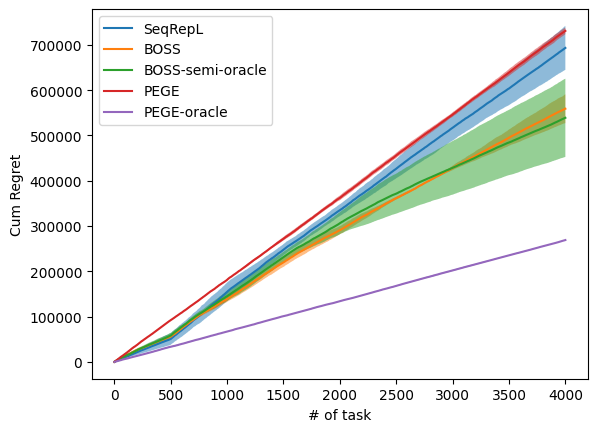

In [65]:
mean_PEGE2 = np.mean(best_PEGE2['regrets'], axis=0)
std_PEGE2 = np.std(best_PEGE2['regrets'], axis=0)
mean_PEGE_oracle2 = np.mean(best_PEGE_oracle2['regrets'], axis=0)
std_PEGE_oracle2 = np.std(best_PEGE_oracle2['regrets'], axis=0)
mean_PMA2 = np.mean(best_PMA2['regrets'], axis=0)
std_PMA2 = np.std(best_PMA2['regrets'], axis=0)
# mean_PMA_stop_exr2 = np.mean(best_PMA_stop_exr2['regrets'], axis=0)
# std_PMA_stop_exr2 = np.std(best_PMA_stop_exr2['regrets'], axis=0)
mean_PMA_no_oracle2 = np.mean(best_PMA_no_oracle2['regrets'], axis=0)
std_PMA_no_oracle2 = np.std(best_PMA_no_oracle2['regrets'], axis=0)
mean_SeqRepL2 = np.mean(best_SeqRepL2['regrets'], axis=0)
std_SeqRepL2 = np.std(best_SeqRepL2['regrets'], axis=0)
X = np.arange(1,n_task+1)
plt.plot(X, mean_SeqRepL2, '-', label='SeqRepL')
plt.fill_between(X, mean_SeqRepL2-std_SeqRepL2, mean_SeqRepL2+std_SeqRepL2, alpha=0.5)
# plt.plot(X, mean_PMA_stop_exr2, '-', label='BOSS-stop-exr')
# plt.fill_between(X, mean_PMA_stop_exr2-std_PMA_stop_exr2, mean_PMA_stop_exr2+std_PMA_stop_exr2, alpha=0.5)
plt.plot(X, mean_PMA_no_oracle2, '-', label='BOSS')
plt.fill_between(X, mean_PMA_no_oracle2-std_PMA_no_oracle2, mean_PMA_no_oracle2+std_PMA_no_oracle2, alpha=0.5)
plt.plot(X, mean_PMA2, '-', label='BOSS-semi-oracle')
plt.fill_between(X, mean_PMA2-std_PMA2, mean_PMA2+std_PMA2, alpha=0.5)
plt.plot(X, mean_PEGE2, '-', label='PEGE')
plt.fill_between(X, mean_PEGE2-std_PEGE2, mean_PEGE2+std_PEGE2, alpha=0.5)
plt.plot(X, mean_PEGE_oracle2, '-', label='PEGE-oracle')
plt.fill_between(X, mean_PEGE_oracle2-std_PEGE_oracle2, mean_PEGE_oracle2+std_PEGE_oracle2, alpha=0.5)
plt.xlabel('# of task')
plt.ylabel('Cum Regret')
plt.legend()
plt.show()
# plt.close()
output_dict = {
    "mean_PEGE2":mean_PEGE2,
    "std_PEGE2":std_PEGE2,
    "mean_PEGE_oracle2":mean_PEGE_oracle2,
    "std_PEGE_oracle2":std_PEGE_oracle2,
    "mean_PMA2":mean_PMA2,
    "std_PMA2":std_PMA2,
    # "mean_PMA_stop_exr2":mean_PMA_stop_exr2,
    # "std_PMA_stop_exr2":std_PMA_stop_exr2,
    "mean_PMA_no_oracle2":mean_PMA_no_oracle2,
    "std_PMA_no_oracle2":std_PMA_no_oracle2,
    "mean_SeqRepL2":mean_SeqRepL2,
    "std_SeqRepL2":std_SeqRepL2,
}
# with open('NoTaskDiv_Dict2.npy', 'wb') as f:
#     np.save(f, output_dict)

In [66]:
# mean_PEGE3 = [mean_PEGE2[0]]
# mean_PEGE_oracle3 = [mean_PEGE_oracle2[0]]
# mean_PMA3 = [mean_PMA2[0]]
# mean_PMA_stop_exr3 = [mean_PMA_stop_exr2[0]]
# mean_PMA_no_oracle3 = [mean_PMA_no_oracle2[0]]
# mean_SeqRepL3 = [mean_SeqRepL2[0]]
# for i in range(1,n_task):
#     mean_PEGE3.append(mean_PEGE2[i]-mean_PEGE2[i-1])
#     mean_PEGE_oracle3.append(mean_PEGE_oracle2[i]-mean_PEGE_oracle2[i-1])
#     mean_PMA3.append(mean_PMA2[i]-mean_PMA2[i-1])
#     mean_PMA_stop_exr3.append(mean_PMA_stop_exr2[i]-mean_PMA_stop_exr2[i-1])
#     mean_PMA_no_oracle3.append(mean_PMA_no_oracle2[i]-mean_PMA_no_oracle2[i-1])
#     mean_SeqRepL3.append(mean_SeqRepL2[i]-mean_SeqRepL2[i-1])
# X = np.arange(1,n_task+1)
# plt.plot(X, mean_SeqRepL3, '-', label='SeqRepL')
# # plt.fill_between(X, mean_SeqRepL3-std_SeqRepL2, mean_SeqRepL3+std_SeqRepL2, alpha=0.5)
# plt.plot(X, mean_PMA_stop_exr3, '-', label='BOSS-stop-exr')
# # plt.fill_between(X, mean_PMA_stop_exr3-std_PMA_stop_exr2, mean_PMA_stop_exr3+std_PMA_stop_exr2, alpha=0.5)
# plt.plot(X, mean_PMA_no_oracle3, '-', label='BOSS-no-oracle')
# # plt.fill_between(X, mean_PMA_no_oracle3-std_PMA_no_oracle2, mean_PMA_no_oracle3+std_PMA_no_oracle2, alpha=0.5)
# plt.plot(X, mean_PMA3, '-', label='BOSS')
# # plt.fill_between(X, mean_PMA3-std_PMA2, mean_PMA3+std_PMA2, alpha=0.5)
# plt.plot(X, mean_PEGE3, '-', label='PEGE')
# # plt.fill_between(X, mean_PEGE3-std_PEGE2, mean_PEGE3+std_PEGE2, alpha=0.5)
# plt.plot(X, mean_PEGE_oracle3, '-', label='PEGE-oracle')
# # plt.fill_between(X, mean_PEGE_oracle3-std_PEGE_oracle2, mean_PEGE_oracle3+std_PEGE_oracle2, alpha=0.5)
# plt.xlabel('# of task')
# plt.ylabel('Avg Cum Regret')
# plt.legend()
# plt.show()

In [67]:
# rbf = Rbf(X, mean_PMA_stop_exr3, function = 'multiquadric', smooth = 500)
# y_PMA_stop_exr_rbf3 = rbf(X)
# rbf = Rbf(X, mean_PMA_no_oracle3, function = 'multiquadric', smooth = 500)
# y_PMA_no_oracle_rbf3 = rbf(X)
# rbf = Rbf(X, mean_PMA3, function = 'multiquadric', smooth = 500)
# y_PMA_rbf3 = rbf(X)
# rbf = Rbf(X, mean_SeqRepL3, function = 'multiquadric', smooth = 500)
# y_SeqRepL_rbf3 = rbf(X)
# rbf = Rbf(X, mean_PEGE3, function = 'multiquadric', smooth = 500)
# y_PEGE_rbf3 = rbf(X)
# rbf = Rbf(X, mean_PEGE_oracle3, function = 'multiquadric', smooth = 500)
# y_PEGE_oracle_rbf3 = rbf(X)

# plt.plot(X, y_SeqRepL_rbf3, '-', label='SeqRepL')
# # plt.fill_between(X, y_SeqRepL_rbf3-std_SeqRepL2, y_SeqRepL_rbf3+std_SeqRepL2, alpha=0.5)
# plt.plot(X, y_PMA_stop_exr_rbf3, '-', label='BOSS-stop-exr')
# # plt.fill_between(X, y_PMA_rbf3-std_PMA_stop_exr2, y_PMA_rbf3+std_PMA_stop_exr2, alpha=0.5)
# plt.plot(X, y_PMA_no_oracle_rbf3, '-', label='BOSS-no-oracle')
# # plt.fill_between(X, y_PMA_no_oracle_rbf3-std_PMA_no_oracle2, y_PMA_no_oracle_rbf3+std_PMA_no_oracle2, alpha=0.5)
# plt.plot(X, y_PMA_rbf3, '-', label='BOSS')
# # plt.fill_between(X, y_PMA_rbf3-std_PMA2, y_PMA_rbf3+std_PMA2, alpha=0.5)

# plt.plot(X, y_PEGE_rbf3, '-', label='PEGE')
# plt.plot(X, y_PEGE_oracle_rbf3, '-', label='PEGE-oracle')


# plt.xlabel('# of task')
# plt.ylabel('Avg Cum Regret smoothed')

# plt.legend()
# plt.show()

<>:20: SyntaxWarning: invalid escape sequence '\h'
<>:20: SyntaxWarning: invalid escape sequence '\h'
/var/folders/pq/3djhrh750zv53df3bfpn596r0000gn/T/ipykernel_27722/1843200279.py:20: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('||\hat(B)_{n, perp}^T B_n||_F')


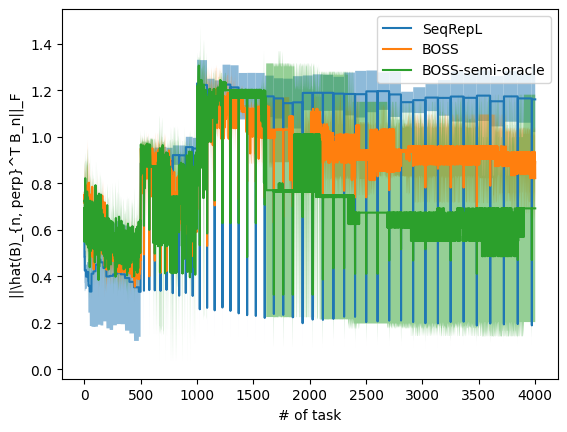

In [68]:
mean_PMA2 = np.mean(best_PMA2['B_hat_err'], axis=0)
std_PMA2 = np.std(best_PMA2['B_hat_err'], axis=0)
mean_SeqRepL2 = np.mean(best_SeqRepL2['B_hat_err'], axis=0)
std_SeqRepL2 = np.std(best_SeqRepL2['B_hat_err'], axis=0)
# mean_PMA_stop_exr2 = np.mean(best_PMA_stop_exr2['B_hat_err'], axis=0)
# std_PMA_stop_exr2 = np.std(best_PMA_stop_exr2['B_hat_err'], axis=0)
mean_PMA_no_oracle2 = np.mean(best_PMA_no_oracle2['B_hat_err'], axis=0)
std_PMA_no_oracle2 = np.std(best_PMA_no_oracle2['B_hat_err'], axis=0)

X = np.arange(1,n_task+1)
plt.plot(X, mean_SeqRepL2, '-', label='SeqRepL')
plt.fill_between(X, mean_SeqRepL2-std_SeqRepL2, mean_SeqRepL2+std_SeqRepL2, alpha=0.5)
# plt.plot(X, mean_PMA_stop_exr2, '-', label='BOSS-stop-exr')
# plt.fill_between(X, mean_PMA_stop_exr2-std_PMA_stop_exr2, mean_PMA_stop_exr2+std_PMA_stop_exr2, alpha=0.5)
plt.plot(X, mean_PMA_no_oracle2, '-', label='BOSS')
plt.fill_between(X, mean_PMA_no_oracle2-std_PMA_no_oracle2, mean_PMA_no_oracle2+std_PMA_no_oracle2, alpha=0.5)
plt.plot(X, mean_PMA2, '-', label='BOSS-semi-oracle')
plt.fill_between(X, mean_PMA2-std_PMA2, mean_PMA2+std_PMA2, alpha=0.5)
plt.xlabel('# of task')
plt.ylabel('||\hat(B)_{n, perp}^T B_n||_F')
plt.legend()
plt.show()
# plt.close()

In [69]:
# # rbf = Rbf(X, mean_PMA_stop_exr2, function = 'multiquadric', smooth = 500)
# # y_PMA_stop_exr_rbf2 = rbf(X)
# rbf = Rbf(X, mean_PMA_no_oracle2, function = 'multiquadric', smooth = 500)
# y_PMA_no_oracle_rbf2 = rbf(X)
# rbf = Rbf(X, mean_PMA2, function = 'multiquadric', smooth = 500)
# y_PMA_rbf2 = rbf(X)
# rbf = Rbf(X, mean_SeqRepL2, function = 'multiquadric', smooth = 500)
# y_SeqRepL_rbf2 = rbf(X)

# plt.plot(X, y_SeqRepL_rbf2, '-', label='SeqRepL')
# plt.fill_between(X, y_SeqRepL_rbf2-std_SeqRepL2, y_SeqRepL_rbf2+std_SeqRepL2, alpha=0.5)
# # plt.plot(X, y_PMA_stop_exr_rbf2, '-', label='BOSS-stop-exr')
# # plt.fill_between(X, y_PMA_rbf2-std_PMA_stop_exr2, y_PMA_rbf2+std_PMA_stop_exr2, alpha=0.5)
# plt.plot(X, y_PMA_no_oracle_rbf2, '-', label='BOSS-no-oracle')
# plt.fill_between(X, y_PMA_no_oracle_rbf2-std_PMA_no_oracle2, y_PMA_no_oracle_rbf2+std_PMA_no_oracle2, alpha=0.5)
# plt.plot(X, y_PMA_rbf2, '-', label='BOSS')
# plt.fill_between(X, y_PMA_rbf2-std_PMA2, y_PMA_rbf2+std_PMA2, alpha=0.5)
# plt.xlabel('# of task')
# plt.ylabel('||\hat(B)_{n, perp}^T B_n||_F')

# plt.legend()
# plt.show()

<>:20: SyntaxWarning: invalid escape sequence '\h'
<>:20: SyntaxWarning: invalid escape sequence '\h'
/var/folders/pq/3djhrh750zv53df3bfpn596r0000gn/T/ipykernel_27722/3272367838.py:20: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('||\hat{theta}_n - theta_n||_2')


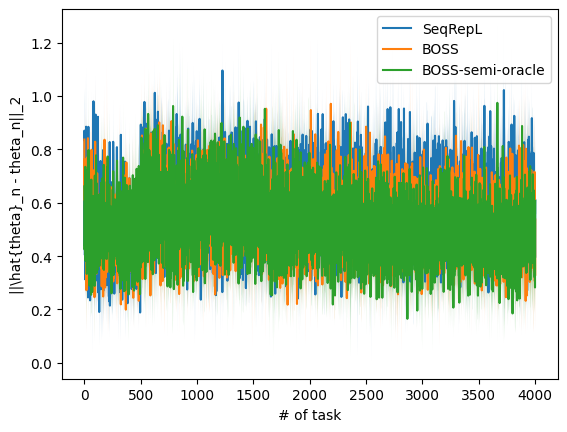

In [70]:
mean_PMA2 = np.mean(best_PMA2['theta_hat_err'], axis=0)
std_PMA2 = np.std(best_PMA2['theta_hat_err'], axis=0)
mean_SeqRepL2 = np.mean(best_SeqRepL2['theta_hat_err'], axis=0)
std_SeqRepL2 = np.std(best_SeqRepL2['theta_hat_err'], axis=0)
# mean_PMA_stop_exr2 = np.mean(best_PMA_stop_exr2['theta_hat_err'], axis=0)
# std_PMA_stop_exr2 = np.std(best_PMA_stop_exr2['theta_hat_err'], axis=0)
mean_PMA_no_oracle2 = np.mean(best_PMA_no_oracle2['theta_hat_err'], axis=0)
std_PMA_no_oracle2 = np.std(best_PMA_no_oracle2['theta_hat_err'], axis=0)

X = np.arange(1,n_task+1)
plt.plot(X, mean_SeqRepL2, '-', label='SeqRepL')
plt.fill_between(X, mean_SeqRepL2-std_SeqRepL2, mean_SeqRepL2+std_SeqRepL2, alpha=0.5)
# plt.plot(X, mean_PMA_stop_exr2, '-', label='BOSS-stop-exr')
# plt.fill_between(X, mean_PMA_stop_exr2-std_PMA_stop_exr2, mean_PMA_stop_exr2+std_PMA_stop_exr2, alpha=0.5)
plt.plot(X, mean_PMA_no_oracle2, '-', label='BOSS')
plt.fill_between(X, mean_PMA_no_oracle2-std_PMA_no_oracle2, mean_PMA_no_oracle2+std_PMA_no_oracle2, alpha=0.5)
plt.plot(X, mean_PMA2, '-', label='BOSS-semi-oracle')
plt.fill_between(X, mean_PMA2-std_PMA2, mean_PMA2+std_PMA2, alpha=0.5)
plt.xlabel('# of task')
plt.ylabel('||\hat{theta}_n - theta_n||_2')
plt.legend()
plt.show()
# plt.close()

<>:19: SyntaxWarning: invalid escape sequence '\h'
<>:19: SyntaxWarning: invalid escape sequence '\h'
/var/folders/pq/3djhrh750zv53df3bfpn596r0000gn/T/ipykernel_27722/1300353887.py:19: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('||\hat{theta}_n - theta_n||_2')


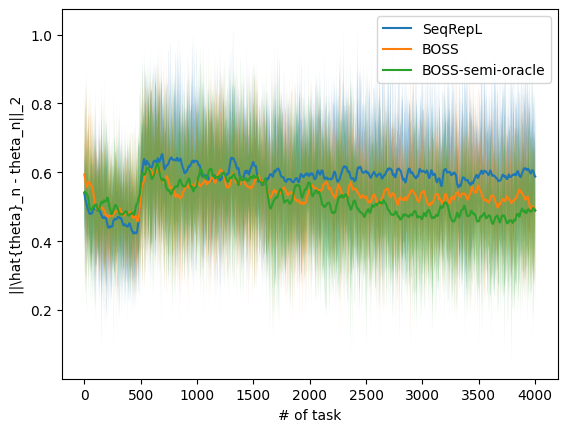

In [71]:
# rbf = Rbf(X, mean_PMA_stop_exr2, function = 'multiquadric', smooth = 500)
# y_PMA_stop_exr_rbf2 = rbf(X)
rbf = Rbf(X, mean_PMA_no_oracle2, function = 'multiquadric', smooth = 500)
y_PMA_no_oracle_rbf2 = rbf(X)
rbf = Rbf(X, mean_PMA2, function = 'multiquadric', smooth = 500)
y_PMA_rbf2 = rbf(X)
rbf = Rbf(X, mean_SeqRepL2, function = 'multiquadric', smooth = 500)
y_SeqRepL_rbf2 = rbf(X)

plt.plot(X, y_SeqRepL_rbf2, '-', label='SeqRepL')
plt.fill_between(X, y_SeqRepL_rbf2-std_SeqRepL2, y_SeqRepL_rbf2+std_SeqRepL2, alpha=0.5)
# plt.plot(X, y_PMA_stop_exr_rbf2, '-', label='BOSS-stop-exr')
# plt.fill_between(X, y_PMA_rbf2-std_PMA_stop_exr2, y_PMA_rbf2+std_PMA_stop_exr2, alpha=0.5)
plt.plot(X, y_PMA_no_oracle_rbf2, '-', label='BOSS')
plt.fill_between(X, y_PMA_no_oracle_rbf2-std_PMA_no_oracle2, y_PMA_no_oracle_rbf2+std_PMA_no_oracle2, alpha=0.5)
plt.plot(X, y_PMA_rbf2, '-', label='BOSS-semi-oracle')
plt.fill_between(X, y_PMA_rbf2-std_PMA2, y_PMA_rbf2+std_PMA2, alpha=0.5)
plt.xlabel('# of task')
plt.ylabel('||\hat{theta}_n - theta_n||_2')

plt.legend()
plt.show()

# Others

In [72]:
# def round(X, precision = .03):
#     return np.round(np.array(X)/precision)*precision
# round(mean_PMA)

In [73]:
# input_dict["name"] = "TS"
# input_dict["params_set"] = v_set
# if is_multi:
#     best_TS = eval_multi(input_dict)
# else:
#     best_TS = eval(input_dict)

# input_dict["name"] = "PEGE"
# input_dict["params_set"] = tau_1_PEGE_set
# if is_multi:
#     best_PEGE = eval_multi(input_dict)
# else:
#     best_PEGE = eval(input_dict)

# input_dict["name"] = "PHE"
# input_dict["params_set"] = alpha_PHE_set
# if is_multi:
#     best_PHE = eval_multi(input_dict)
# else:
#     best_PHE = eval(input_dict)

In [74]:
# input_dict["n_sim"] = 3

# input_dict["name"] = "UCB"
# input_dict["params_set"] = alpha_set
# best_UCB = eval(input_dict)

# input_dict["name"] = "TS"
# input_dict["params_set"] = v_set
# best_TS = eval(input_dict)

# mean_UCB = np.mean(best_UCB['regrets'], axis=0)
# std_UCB = np.std(best_UCB['regrets'], axis=0)
# mean_TS = np.mean(best_TS['regrets'], axis=0)
# std_TS = np.std(best_TS['regrets'], axis=0)
# X = np.arange(1,T+1)
# plt.plot(X, mean_TS, '-', label='TS')
# plt.fill_between(X, mean_TS-std_TS, mean_TS+std_TS, alpha=0.5)
# plt.plot(X, mean_UCB, '-', label='UCB')
# plt.fill_between(X, mean_UCB-std_UCB, mean_UCB+std_UCB, alpha=0.5)
# plt.xlabel('# of step')
# plt.ylabel('Cum Regret')
# plt.legend()
# plt.show()
# plt.close()